In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
!pip install import_ipynb
import import_ipynb
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_absolute_error


# select the style from fivethityeight website
mpl.rcdefaults() 
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.figsize'] = (12,8)

# Set the seed for random operations
SEED = 1234
np.random.seed(SEED) 


# mount google drive to access Covid data and to import notebook with Parser class
cwd = os.getcwd()
drive.mount('/content/drive')
%cd drive/MyDrive/hmw3

import Parser

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1fgnDLwnKLOQ1Zol2r7e7lbuqZlxJZlhQ/hmw3
importing Jupyter notebook from Parser.ipynb


In [2]:
# Parsing

# where to find data on google drive 
direct = 'COVID-19/dati-regioni'

region_names = ('Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
                'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia', 'Sardegna', 'Sicilia', 'Toscana', 'Umbria', 'Valle d\'Aosta', 'Veneto')

# columns that will be parsed from covid datasets  
column_names = ['data', 'lat', 'long', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'totale_positivi', 'variazione_totale_positivi', 'nuovi_positivi',
                'dimessi_guariti', 'deceduti', 'tamponi'] 


parser = Parser.COVID19_parser(directory=direct, region_names=region_names, column_names=column_names, min_date='20210101', vax=True)

parser.parse()

100%|██████████| 515/515 [00:55<00:00,  9.28it/s]


In [3]:
def ADFuller(df):
    # test for stationarity of a time series
    # can be summarised as:
    # H0: time series is a RW (not stationary) vs H1: time series is stationary 
    index=df.index
    columns = df.columns
    df_stats = pd.DataFrame(columns=['p-value'], index=columns)
    for col in columns:
        df_stats.loc[col]=adfuller(df[col], autolag='AIC')[1]
    return df_stats

def preprocessing(region_name, date_init, name_col, r_window = 1, diff = False, r_window_diff = 1):
  
  df = parser.region_dict[region_name].copy()
  df = df[date_init:]
  df.dropna(inplace = True)
  if diff: 
    new_name = 'nuovi_' + name_col
    df[new_name] = df[name_col].diff()
    df[new_name] = df[new_name].rolling(window = r_window_diff).mean()



  # smoothing of data 
  df[name_col] = df[name_col].rolling(window = r_window).mean()
  df.dropna(inplace = True)
  # plot of smoothed data 
  if diff: 
    df[[name_col,new_name]].plot(subplots = True) 
  else:
    df[name_col].plot(title = name_col); 

  print("pvalue ADFuller test: ")
  if diff:
    print(ADFuller(df[[name_col, new_name]]))
  else: 
    print(ADFuller(df[[name_col]]))

  # plot autocorrelation function and partial autocorrelation function, to have an idea of parameters of ARIMA model 
  plot_acf(df[name_col].iloc[-128:], title = 'Autocorrelation '+ name_col) 
  plot_pacf(df[name_col], title = 'Partial Autocorrelation '+ name_col) # values greater than one are due to the smoothing phase, which created autocorrelations
  if diff:
    plot_acf(df[new_name].iloc[-128:], title = 'Autocorrelation '+ new_name) 
    plot_pacf(df[new_name], title = 'Partial Autocorrelation '+ new_name) 
  plt.show()

  return df

In [4]:
class fit_ARIMA(): 
  def __init__(self):
    '''
    Dictionaries containing BIC related to ARIMA models trained using data from 01-01-2021 to 23-05-2022
    regionname_BIC = {category:[(BIC,ar,dif,ma)]
                       'last_day': {last day for training data for each category} }
    where category represents the new infections/new deceased/ new recovered
    '''
    
    self.__Lombardia_BIC = {'nuovi_positivi':[(7565.741344893988, 1, 1, 1),(7558.78542000171, 1, 1, 2),(7535.095468334074, 1, 1, 3),(7527.656727653167, 1, 1, 4),(7521.163434409357, 1, 1, 5),(7522.398654810381, 1, 1, 6),(7557.920757413264, 1, 2, 1),(7550.808525059767, 1, 2, 2),(7526.973629751709, 1, 2, 3),(7531.543892913094, 1, 2, 4),(7529.527772364368, 1, 2, 5),(7524.001497224357, 1, 2, 6),(7565.024268424335, 2, 1, 1),(7558.167536568971, 2, 1, 2),(7522.346897093236, 2, 1, 3),(7528.559006617442, 2, 1, 4),(7525.942566410094, 2, 1, 5),(7523.4510809326575, 2, 1, 6),(7533.590395769379, 2, 2, 1),(7513.0563027384005, 2, 2, 2),(7511.101203647375, 2, 2, 3),(7517.307886017607, 2, 2, 4),(7499.665570881878, 2, 2, 5),(7505.614705917459, 2, 2, 6),(7541.090973440051, 3, 1, 1),(7514.535243036756, 3, 1, 2),(7515.391827975897, 3, 1, 3),( 7521.311997537056, 3, 1, 4),( 7500.800674880405, 3, 1, 5),( 7491.585276974588, 3, 1, 6),( 7525.60587105524, 3, 2, 1),( 7513.386758365916, 3, 2, 2),( 7517.310730094511, 3, 2, 3),( 7521.808421455178, 3, 2, 4),(7505.8772249607655, 3, 2, 5),( 7495.866754299538, 3, 2, 6),( 7533.448677937086, 4, 1, 1),( 7516.1477841063925, 4, 1, 2),( 7526.594535355763, 4, 1, 3),( 7526.53668343098, 4, 1, 4),( 7506.828963885965, 4, 1, 5),(7497.001762900366, 4, 1, 6),(7500.908284213463, 4, 2, 1),(7502.381887833385, 4, 2, 2),(7500.104944292825, 4, 2, 3),( 7509.183301217649, 5, 1, 1),( 7507.991266237984, 5, 1, 2),( 7507.1055320787245, 5, 1, 3),( 7507.341480695158, 5, 1, 4),( 7509.029832254254, 5, 1, 5),( 7481.122464952697, 5, 1, 6),( 7503.499881754665, 5, 2, 1),( 7508.952123665273, 5, 2, 2),( 7505.523970231311, 5, 2, 3),( 7507.1040306052755, 5, 2, 4),( 7512.376370559659, 5, 2, 5),( 7518.307367598517, 5, 2, 6),( 7496.743846799659, 6, 1, 1),( 7498.619435468027, 6, 1, 2),( 7512.367539305092, 6, 1, 3),( 7503.192773864191, 6, 1, 4),( 7505.684134618613, 6, 1, 5),( 7484.038677268013, 6, 1, 6),( 7494.289286225183, 6, 2, 1),( 7480.455578142669, 6, 2, 2),( 7493.36966179309, 6, 2, 3),( 7505.745875173892, 6, 2, 4),( 7499.306842246037, 7, 1, 1),( 7499.362293776851, 7, 1, 2),( 7494.379399246541, 7, 1, 3),(7493.136693582358, 7, 1, 4),( 7499.564250252158, 7, 2, 1),( 7506.563589547294, 7, 2, 2),( 7483.6661721204255, 7, 2, 3),( 7494.975302409785, 7, 2, 4),( 7499.619175323178, 7, 2, 5),( 7505.434422768308, 8, 1, 1),( 7497.297420973794, 8, 1, 2),(7482.438444948498, 8, 1, 3),(7488.63690296498, 8, 1, 4),( 7501.0048627846145, 8, 2, 1),( 7503.956648551761, 8, 2, 2),(7507.433437744402, 8, 2, 3),(7491.001388027018, 8, 2, 4),(7485.364657078729, 8, 2, 5),(7512.807620803291, 8, 2, 6),(7500.169689197231, 9, 1, 1),( 7503.014081483708, 9, 1, 2),(7509.990887033212, 9, 1, 3),(7489.547152771365, 9, 2, 1),( 7509.048999104404, 9, 2, 2),(7513.252806209868, 9, 2, 3),(7505.0831746939775, 9, 2, 4),(7506.242557837977, 9, 2, 5),(7499.535805078991, 9, 2, 6),(7496.7787228350235, 10, 1, 1),( 7515.045857268814, 10, 1, 3),(7512.6130100982, 10, 2, 1),( 7514.858661893844, 10, 2, 2),( 7504.522094773378, 10, 2, 5),( 7488.802486675869, 10, 2, 6),( 7511.191992416122, 11, 1, 1),( 7509.19788337515, 11, 1, 2),( 7513.434073310416, 11, 1, 3),( 7513.196703954029, 11, 2, 1),( 7511.845839310025, 11, 2, 2),(7492.045325042915, 11, 2, 3),( 7504.211727352724, 11, 2, 4),( 7493.952430825718, 11, 2, 5),( 7490.379443332455, 11, 2, 6),(7515.253025646002, 12, 1, 1),( 7513.398006079664, 12, 1, 2),( 7519.283298588565, 12, 1, 3),(7514.912437211723, 12, 2, 1),( 7517.954381496653, 12, 2, 2),( 7523.845324482521, 12, 2, 3),( 7528.340898174095, 12, 2, 4),( 7531.485908235905, 12, 2, 5),( 7508.990538435798, 12, 2, 6),( 7508.56163640914, 13, 1, 1),( 7514.275023999078, 13, 1, 2),( 7520.051082728996, 13, 1, 4),( 7503.616677755506, 13, 1, 5),(7504.102704464816, 13, 1, 6),( 7514.032496441943, 13, 2, 1),(7498.345185591551, 13, 2, 3),(7512.751052000487, 13, 2, 4),(7518.241099128979, 13, 2, 5),(7513.018595315443, 13, 2, 6)],
                             'nuovi_deceduti':[(2111.4997634827155, 1, 1, 1),(2114.4405892241034, 1, 1, 2),(2114.438841208246, 1, 1, 3),(2127.0700524020435, 1, 1, 4),(2118.7457775986413, 1, 1, 5),(2059.719207763441, 1, 1, 6),(2008.2615778332247, 1, 1, 7),(2118.2342831291253, 1, 2, 1),(2125.8505359501282, 1, 2, 2),(2123.870174453184, 1, 2, 3),(2127.915252524267, 1, 2, 4),(2133.4845960793914, 1, 2, 5),(2126.6052711151515, 1, 2, 6),(2115.28225944526, 2, 1, 1),(2113.6965976122665, 2, 1, 2),(2104.7789007236233, 2, 1, 3),(2108.7954605287828, 2, 1, 4),(2062.747793214169, 2, 1, 5),(2027.5117977613968, 2, 1, 6),(2010.2679990163365, 2, 1, 7),(2119.023182562231, 2, 2, 1),(2123.465939450165, 2, 2, 2),(2109.7530336802074, 2, 2, 3),(2104.3214776750788, 2, 2, 4),(2087.2835676737373, 2, 2, 5),(2070.6937893553945, 2, 2, 6),(2035.266133908583, 2, 2, 7),(2114.3333339915566, 3, 1, 1),(2119.4850489779574, 3, 1, 2),(2099.84082415603, 3, 1, 3),(2102.276184138067, 3, 1, 4),(2081.721692115694, 3, 1, 5),(2072.2586867970263, 3, 1, 6),(2038.349507448219, 3, 1, 7),(2124.712288952149, 3, 2, 1),(2129.6449884121866, 3, 2, 2),(2084.298770114881, 3, 2, 3),(2089.1477610318207, 3, 2, 4),(2092.853129745842, 3, 2, 5),(2065.7502741859935, 3, 2, 6),(2029.9015577466994, 3, 2, 7),(2120.49851564069, 4, 1, 1),(2125.663373392188, 4, 1, 2),(2080.1443780436916, 4, 1, 3),(2085.6521608350886, 4, 1, 4),(2087.4832958903075, 4, 1, 5),(2058.818579451967, 4, 1, 6),(2033.21817134209, 4, 1, 7),(2127.811844327356, 4, 2, 1),(2133.455286097543, 4, 2, 2),(2089.6575371636836, 4, 2, 3),(2095.3574313575095, 4, 2, 4),(2113.8522044824517, 4, 2, 5),(2048.0878049376915, 4, 2, 6),(2018.361263057425, 4, 2, 7),(2113.622388044565, 5, 1, 1),(2083.770959360159, 5, 1, 2),(2065.773229354651, 5, 1, 3),(2050.5066407825257, 5, 1, 4),(2053.44149553286, 5, 1, 5),(2015.0441846501017, 5, 1, 6),(2017.6422254678664, 5, 1, 7),(2113.0741001961114, 5, 2, 1),(2077.622086661419, 5, 2, 2),(2081.595369480078, 5, 2, 3),(2083.030186433567, 5, 2, 4),(2085.749052420874, 5, 2, 5),(2052.597893967943, 5, 2, 6),(2018.3786041798776, 5, 2, 7),(2100.375589137663, 6, 1, 1),(2057.044163981382, 6, 1, 2),(2063.2500290436146, 6, 1, 3),(2069.779720283212, 6, 1, 4),(2062.7624492850127, 6, 1, 5),(2019.575763142811, 6, 1, 6),(2016.6829351228314, 6, 1, 7),(2111.48216984081, 6, 2, 1),(2082.093990504141, 6, 2, 2),(2064.3721875000692, 6, 2, 3),(2070.5680255910843, 6, 2, 4),(2062.351899749333, 6, 2, 5),(2050.029064053036, 6, 2, 6),(2014.765490443458, 6, 2, 7),(2089.1277749159185, 7, 1, 1),(2063.2488036025866, 7, 1, 2),(2069.1172415676174, 7, 1, 3),(2074.6156884785623, 7, 1, 4),(2042.2286129941983, 7, 1, 5),(2045.9849593043302, 7, 1, 6),(2012.3656592968707, 7, 1, 7),(2083.924035816878, 7, 2, 1),(2072.650404666863, 7, 2, 2),(2076.8991927048264, 7, 2, 3),(2076.4615402168156, 7, 2, 4),(2081.6359284100827, 7, 2, 5),(2052.755153860572, 7, 2, 6),(2020.8505238517191, 7, 2, 7),(2081.10120206496, 8, 1, 1),(2063.1901424874336, 8, 1, 2),(2074.7642181049137, 8, 1, 3),(2074.284611204936, 8, 1, 4),(2051.4456214174998, 8, 1, 5),(2055.081628578519, 8, 1, 6),(2018.3815283225385, 8, 1, 7),(2073.846206378158, 8, 2, 1),(2078.7147624064, 8, 2, 2),(2083.4372627486455, 8, 2, 3),(2088.480267816859, 8, 2, 4),(2054.5591928976105, 8, 2, 5),(2058.961802875137, 8, 2, 6),(2070.66610333454, 9, 1, 1),(2063.426190381591, 9, 1, 2),(2069.5899282320183, 9, 1, 3),(2075.70888964346, 9, 1, 4),(2061.420397272451, 9, 1, 5),(2055.227675163615, 9, 1, 6),(2075.457566577852, 9, 2, 1),(2081.655784412194, 9, 2, 2),(2071.825563070895, 9, 2, 3),(2078.0096745752494, 9, 2, 4),(2083.5146807789088, 9, 2, 5),(2056.3709003634126, 9, 2, 6),(2070.8546234511764, 10, 1, 1),(2068.1719947811503, 10, 1, 2),(2068.4299480718037, 10, 1, 3),(2074.454826728637, 10, 1, 4),(2071.038902282703, 10, 1, 5),(2027.7984727057813, 10, 1, 6),(2081.6665508060464, 10, 2, 1),(2032.058781801519, 10, 2, 2),(2078.015707385592, 10, 2, 3),(2084.009918896679, 10, 2, 4),(2089.6519205472528, 10, 2, 5),(2040.4687967417838, 10, 2, 6),(2076.837761397383, 11, 1, 1),(2025.9015182573442, 11, 1, 2),(2074.5188535048464, 11, 1, 3),(2074.693607623365, 11, 1, 4),(2080.2062441080557, 11, 1, 5),(2023.1784235043017, 11, 1, 6),(2085.1766410020173, 11, 2, 1),(2068.2175692911896, 11, 2, 2),(2074.2668092926774, 11, 2, 3),(2068.5762202704063, 11, 2, 4),(2082.138020888267, 11, 2, 5),(2049.1139005448695, 11, 2, 6),(2079.2920634382263, 12, 1, 1),(2064.850035656413, 12, 1, 2),(2071.0502456934328, 12, 1, 3),(2065.914826292615, 12, 1, 4),(2078.7670499612777, 12, 1, 5),(2030.6794670488562, 12, 1, 6),(2075.0960616230095, 12, 2, 1),(2042.174692048071, 12, 2, 2),(2072.631727328171, 12, 2, 3),(2039.4483859668187, 12, 2, 4),(2057.72553994824, 12, 2, 5),(2032.5966510860133, 12, 2, 6),(2073.554343997331, 13, 1, 1),(2037.2869761577633, 13, 1, 2),(2070.4765496914188, 13, 1, 3),(2029.799397849559, 13, 1, 4),(2035.9769749476743, 13, 1, 5),(2030.0754738685437, 13, 1, 6),(2064.784984433845, 13, 2, 1),(2069.5622160048697, 13, 2, 2),(2075.2695326417747, 13, 2, 3),(2036.0075226287604, 13, 2, 4),(2042.2339368283629, 13, 2, 5)], 
                             'nuovi_dimessi_guariti':[(8114.631481636209, 1, 1, 1),( 8099.521557040334, 1, 1, 2),( 7998.841978701353, 1, 1, 3),( 8115.210237530107, 1, 2, 1),( 8082.094421142021, 1, 2, 2),( 8064.529470971363, 1, 2, 3),( 7939.343979939302, 1, 2, 5),( 7943.432749187831, 1, 2, 6),( 8118.1040854956445, 2, 1, 1),( 8032.9235400696825, 2, 1, 2),( 7995.1813116108115, 2, 1, 3),( 8087.85432058167, 2, 2, 1),( 7946.325078690033, 2, 2, 2),( 7914.05071176552, 2, 2, 3),( 8030.062277058718, 2, 2, 4),( 7937.419028480345, 2, 2, 5),( 7929.032627433053, 2, 2, 6),( 8090.051585921895, 3, 1, 1),( 7919.491010207868, 3, 1, 2),( 7908.775401022277, 3, 1, 3),( 7954.576507377342, 3, 1, 4),( 7914.122118564787, 3, 1, 5),( 8036.580111275855, 3, 2, 1),( 7910.98687312102, 3, 2, 2),( 7918.275270208139, 3, 2, 3),( 7914.727146302134, 3, 2, 4),( 7919.847898031336, 3, 2, 5),( 7921.690991075049, 3, 2, 6),( 8039.720784334848, 4, 1, 1),( 7902.458035002618, 4, 1, 2),( 7902.155382873396, 4, 1, 3),( 7906.659820790311, 4, 1, 4),( 7912.612226054288, 4, 1, 5),( 7905.782755677639, 4, 1, 6),( 8040.40923768972, 4, 2, 1),( 7917.112849733332, 4, 2, 2),( 7918.1822193234375, 4, 2, 3),( 7903.778427114007, 4, 2, 4),( 7891.579097791265, 4, 2, 5),( 7897.771683936356, 4, 2, 6),( 7904.536982917504, 4, 2, 7),( 8044.134293413556, 5, 1, 1),( 7907.622106524037, 5, 1, 2),( 7907.024088125977, 5, 1, 3),( 7894.686460982694, 5, 1, 4),( 7885.850774691806, 5, 1, 5),( 7900.649958562287, 5, 1, 6),( 7904.8528365657985, 5, 1, 7),( 8023.786088038563, 5, 2, 1),( 7971.916792778877, 5, 2, 2),( 7916.3392742299875, 5, 2, 3),( 7901.674213646981, 5, 2, 4),( 7889.561748987368, 5, 2, 6),( 8030.649879539982, 6, 1, 1),( 7913.598865336314, 6, 1, 2),( 7910.93129356115, 6, 1, 3),( 7896.954034390563, 6, 1, 4),( 7892.192686030495, 6, 1, 5),( 7869.877721810537, 6, 1, 6),( 7875.5118250798705, 6, 1, 7),( 7983.626942869005, 6, 2, 1),( 7920.514189864929, 6, 2, 2),( 7918.046180558269, 6, 2, 3),( 7902.708989094979, 6, 2, 4),( 7889.569545121697, 6, 2, 5),( 7893.398101261925, 6, 2, 6),( 7866.358527303301, 6, 2, 7),( 7962.438498909453, 7, 1, 1),( 7905.064940535295, 7, 1, 2),( 7904.028027587554, 7, 1, 3),(7889.523210749169, 7, 1, 4),( 7874.670779160773, 7, 1, 5),( 7859.227790697674, 7, 1, 7),( 7969.368700377573, 7, 2, 1),( 7975.1483806500055, 7, 2, 2),( 7913.1989801366935, 7, 2, 3),( 7883.207864495302, 7, 2, 4),( 7879.864389739102, 7, 2, 5),(7869.519590375799, 7, 2, 6),( 7845.903236191349, 7, 2, 7),( 7949.20505961369, 8, 1, 1),( 7955.080989773722, 8, 1, 2),(7907.02255442102, 8, 1, 3),( 7879.8239804162895, 8, 1, 4),(7874.6937961029225, 8, 1, 5),( 7859.665238321211, 8, 1, 6),( 7850.746009504797, 8, 1, 7),( 7939.225216460373, 8, 2, 1),( 7944.944056666569, 8, 2, 2),( 7916.345910795993, 8, 2, 3),(7879.821866839726, 8, 2, 4),( 7884.238928271135, 8, 2, 5),( 7869.756603554622, 8, 2, 6),( 7850.6402193593, 8, 2, 7),(7953.928857158988, 9, 1, 1),( 7960.608246517305, 9, 1, 2),( 7912.27671129862, 9, 1, 3),( 7866.666361287239, 9, 1, 4),( 7872.617588445137, 9, 1, 5),( 7858.587852262648, 9, 1, 6),(7858.204045018737, 9, 1, 7),( 7945.020175752888, 9, 2, 1),( 7950.226239262649, 9, 2, 2),( 7917.508312206264, 9, 2, 3),( 7882.203716107879, 9, 2, 4),( 7891.914619423954, 9, 2, 5),( 7856.722336284775, 9, 2, 7),( 7959.823356032865, 10, 1, 1),( 7931.602541602788, 10, 1, 2),( 7904.825081136904, 10, 1, 3),( 7872.571207081677, 10, 1, 4),( 7878.063457536651, 10, 1, 5),( 7864.403704955779, 10, 1, 7),( 7958.182868791088, 10, 2, 1),( 7908.7732681419875, 10, 2, 2),( 7914.822386390939, 10, 2, 3),( 7886.050958805948, 10, 2, 4),( 7890.127878595393, 10, 2, 5),( 7873.496929387116, 10, 2, 6),( 7958.728089751836, 11, 1, 1),( 7904.148460857646, 11, 1, 2),( 7909.312395966517, 11, 1, 3),( 7878.743685313359, 11, 1, 4),( 7882.285928855704, 11, 1, 5),( 7865.179682611877, 11, 1, 6),( 7955.7959915914025, 11, 2, 1),( 7914.743888718396, 11, 2, 2),( 7920.844464396468, 11, 2, 3),(7927.206673094469, 11, 2, 4),( 7896.775215847107, 11, 2, 5),( 7877.59331445067, 11, 2, 6),( 7957.181751198957, 12, 1, 1),( 7907.703220080633, 12, 1, 2),( 7915.8325542079365, 12, 1, 3),( 7887.472040957704, 12, 1, 5),( 7870.970870541109, 12, 1, 6),( 7948.597137649613, 12, 2, 1),( 7939.574655511751, 12, 2, 2),( 7926.638446615256, 12, 2, 3),( 7905.694380912375, 12, 2, 4),( 7919.421301394403, 12, 2, 5),( 7882.5018568189225, 12, 2, 6),( 7952.246074738874, 13, 1, 1),( 7901.021485608897, 13, 1, 4),( 7914.959118647995, 13, 1, 5),( 7940.584857423719, 13, 2, 1),( 7944.6070423470555, 13, 2, 2),( 7950.563312680082, 13, 2, 3),( 7917.103900476322, 13, 2, 4),(7896.363686007873, 13, 2, 5),( 7910.271022837604, 13, 2, 6)],
                             'totale_ospedalizzati':[(3354.118526603563, 1, 1, 1),(3333.2583474136604, 1, 1, 2),(3331.961016979753, 1, 1, 3),(3285.431184455595, 1, 1, 4),(3272.3534473321215, 1, 1, 5),(3244.1747644832617, 1, 1, 6),(3165.5597733306467, 1, 1, 7),(3266.046220964093, 1, 2, 1),(3270.235821304004, 1, 2, 2),(3268.056504411284, 1, 2, 3),(3262.6748850340236, 1, 2, 4),(3264.3763323413277, 1, 2, 5),(3171.6666545760504, 1, 2, 6),(3155.5188719913076, 1, 2, 7),(3265.65879624521, 2, 1, 1),(3270.819654373516, 2, 1, 2),(3272.2057761957544, 2, 1, 3),(3271.0655311593046, 2, 1, 4),(3273.569586559429, 2, 1, 5),(3178.902106071373, 2, 1, 6),(3165.8586546086967, 2, 1, 7),(3270.743743562797, 2, 2, 1),(3276.683330183097, 2, 2, 2),(3279.5240283333856, 2, 2, 3),(3232.4917170350245, 2, 2, 4),(3231.1183004223662, 2, 2, 5),(3161.475898756059, 2, 2, 6),(3159.434214177192, 2, 2, 7),(3271.031809740263, 3, 1, 1),(3276.670760362375, 3, 1, 2),(3280.2908872421017, 3, 1, 3),(3242.2481536867554, 3, 1, 4),(3234.981824497111, 3, 1, 5),(3170.033690126092, 3, 1, 6),(3184.766071475116, 3, 1, 7),(3274.4523596994186, 3, 2, 1),(3280.246572785064, 3, 2, 2),(3278.0116675656463, 3, 2, 3),(3210.859316788254, 3, 2, 4),(3205.940954214769, 3, 2, 5),(3154.326550086033, 3, 2, 6),(3173.86157256723, 3, 2, 7),(3275.2269761592834, 4, 1, 1),(3280.625297286706, 4, 1, 2),(3283.6376959647278, 4, 1, 3),(3213.8432213476094, 4, 1, 4),(3240.8103856118705, 4, 1, 5),(3164.8651651425307, 4, 1, 6),(3174.55479788932, 4, 1, 7),(3273.280728745938, 4, 2, 1),(3279.5044167545534, 4, 2, 2),(3251.8451306540414, 4, 2, 3),(3210.5825715900214, 4, 2, 4),(3255.196950077114, 4, 2, 5),(3160.4105722295662, 4, 2, 6),(3162.139075521959, 4, 2, 7),(3273.8134378479367, 5, 1, 1),(3280.4477045794333, 5, 1, 2),(3256.653316205111, 5, 1, 3),(3261.3472451114585, 5, 1, 4),(3262.079744976975, 5, 1, 5),(3170.7013531457224, 5, 1, 6),(3162.6776919050576, 5, 1, 7),(3278.161773839648, 5, 2, 1),(3254.339345668272, 5, 2, 2),(3254.566679773566, 5, 2, 3),(3206.067404869789, 5, 2, 4),(3201.9982987364037, 5, 2, 5),(3165.134260403206, 5, 2, 6),(3167.1562130400835, 5, 2, 7),(3277.9130893847487, 6, 1, 1),(3256.6624422130544, 6, 1, 2),(3259.485487773077, 6, 1, 3),(3265.670417984281, 6, 1, 4),(3205.1935679753205, 6, 1, 5),(3174.4841610513513, 6, 1, 6),(3167.6824385749874, 6, 1, 7),(3273.9352304184963, 6, 2, 1),(3245.72571616736, 6, 2, 2),(3236.494043612495, 6, 2, 3),(3194.166204702301, 6, 2, 4),(3202.425466887119, 6, 2, 5),(3171.3011513989786, 6, 2, 6),(3173.279387027894, 6, 2, 7),(3270.7602479137404, 7, 1, 1),(3245.702930649152, 7, 1, 2),(3238.274976134214, 7, 1, 3),(3198.9987663349475, 7, 1, 4),(3203.755933937353, 7, 1, 5),(3180.644041593184, 7, 1, 6),(3173.803662311477, 7, 1, 7),(3232.847646350067, 7, 2, 1),(3229.9007163769006, 7, 2, 2),(3236.0618145005155, 7, 2, 3),(3200.22809686809, 7, 2, 4),(3197.69050815268, 7, 2, 5),(3169.0946483835196, 7, 2, 6),(3173.373581464614, 7, 2, 7),(3239.558785059179, 8, 1, 1),(3234.964411530783, 8, 1, 2),(3241.1634225029984, 8, 1, 3),(3204.340980246409, 8, 1, 4),(3185.3270740240782, 8, 1, 5),(3176.2336457428332, 8, 1, 6),(3174.9630201426344, 8, 1, 7),(3220.4211759270524, 8, 2, 1),(3183.591903595052, 8, 2, 2),(3183.6029978450506, 8, 2, 3),(3182.2179136715267, 8, 2, 4),(3187.7163261884416, 8, 2, 5),(3174.9153984103855, 8, 2, 6),(3228.5278685138737, 9, 1, 1),(3186.8756151954312, 9, 1, 2),(6744.3716583273435, 9, 1, 5),(3181.4538752750464, 9, 1, 6),(3205.2722640333277, 9, 2, 1),(3179.1691672555944, 9, 2, 2),(3185.3381154092785, 9, 2, 3),(3184.347218620102, 9, 2, 4),(3190.291574030651, 9, 2, 5),(3178.5246755487583, 9, 2, 6),(3208.7372881559177, 10, 1, 1),(3214.7935288802732, 10, 1, 2),(3195.122894977866, 10, 1, 3),(3191.2702172485347, 10, 1, 5),(3211.170293550402, 10, 2, 1),(3185.250772763696, 10, 2, 2),(3188.8593985784137, 10, 2, 3),(3185.681718191424, 10, 2, 4),(3188.894801584552, 10, 2, 5),(3182.442436893299, 10, 2, 6),(3190.150901944665, 10, 2, 7),(3214.9517057311723, 11, 1, 1),(3218.6048186759417, 11, 1, 2),(3189.3278914291736, 11, 1, 3),(3187.630389893739, 11, 1, 4),(3192.822379896062, 11, 1, 5),(3190.653781922667, 11, 1, 7),(3212.1816106000333, 11, 2, 1),(3180.434185707683, 11, 2, 2),(3184.6640368811345, 11, 2, 3),(3187.200426090637, 11, 2, 4),(3193.3624256336266, 11, 2, 5),(3179.7021195230536, 11, 2, 6),(3184.140344980981, 11, 2, 7),(3212.5999766351674, 12, 1, 1),(3182.1755251738655, 12, 1, 2),(3188.1041883218663, 12, 1, 3),(3191.3733698955016, 12, 1, 4),(3197.5826100699423, 12, 1, 5),(3180.772111268211, 12, 1, 6),(3186.608177668908, 12, 1, 7),(3215.6241928410936, 12, 2, 1),(3185.843758362345, 12, 2, 2),(3225.474511572856, 12, 2, 3),(3196.7120930633696, 12, 2, 4),(3205.177116408836, 12, 2, 5),(3195.5661297486276, 12, 2, 6),(3179.7819094479382, 12, 2, 7),(3217.836665467335, 13, 1, 1),(3188.3230871686515, 13, 1, 2),(3205.4101078247177, 13, 1, 5),(3217.8965337394015, 13, 2, 1),(3191.0133949795136, 13, 2, 2),(3213.8984749524325, 13, 2, 3),(3191.8201364014985, 13, 2, 4),(3197.7041436294094, 13, 2, 5),(3207.322985572294, 13, 2, 6)], 
                             'last_day' : {'nuovi_positivi':'2022-05-23', 'nuovi_deceduti':'2022-05-23', 'nuovi_dimessi_guariti':'2022-05-23', 'totale_ospedalizzati':'2022-05-23'}}
    self.__Lazio_BIC = {'nuovi_positivi':[( 6409.9085908166, 1, 1, 1),(6411.796463317009, 1, 1, 2),(6394.054250873257, 1, 1, 3),(6372.354719304797, 1, 1, 4),(6372.0830614998295, 1, 1, 5),( 6358.626223017313, 1, 1, 6),(6364.785629012283, 1, 1, 7),(6414.214766486858, 1, 2, 1),(6416.750224302217, 1, 2, 2),( 6405.324146114591, 1, 2, 3),( 6403.718767904938, 1, 2, 4),( 6370.154361110856, 1, 2, 5),( 6370.236135727302, 1, 2, 6),( 6356.963880496412, 1, 2, 7),( 6413.557253980505, 2, 1, 1),( 6416.242063668172, 2, 1, 2),(6381.905604765226, 2, 1, 3),( 6377.842486591225, 2, 1, 4),( 6378.048914446878, 2, 1, 5),( 6377.240071922187, 2, 1, 6),( 6362.8260939917445, 2, 1, 7),( 6408.649656096628, 2, 2, 1),( 6361.068264368626, 2, 2, 2),( 6362.697333498732, 2, 2, 3),( 6364.955547432285, 2, 2, 4),( 6374.301195877586, 2, 2, 5),( 6359.68137476583, 2, 2, 6),( 6348.718940450634, 2, 2, 7),( 6407.67411393983, 3, 1, 1),(6347.283952149844, 3, 1, 2),(6352.784471759062, 3, 1, 3),( 6352.493329065103, 3, 1, 4),(6349.785887418949, 3, 1, 5),(6353.74275670553, 3, 1, 6),(6349.9364433335095, 3, 1, 7),(6402.375466996941, 3, 2, 1),(6361.935548442887, 3, 2, 2),(6367.718904850845, 3, 2, 3),(6371.052305893018, 3, 2, 4),(6375.433650519509, 3, 2, 5),(6347.561529954627, 3, 2, 6),(6354.871455254968, 3, 2, 7),( 6402.81416832692, 4, 1, 1),( 6352.576120135552, 4, 1, 2),( 6358.032690432047, 4, 1, 3),(6356.079490348332, 4, 1, 4),( 6355.296483996709, 4, 1, 5),( 6361.778422605027, 4, 1, 6),( 6355.562627608983, 4, 1, 7),(6402.418383986011, 4, 2, 1),( 6367.3580094797535, 4, 2, 2),( 6373.47647409855, 4, 2, 3),( 6351.444974617248, 4, 2, 4),( 6357.41939566464, 4, 2, 5),( 6360.943874032266, 4, 2, 6),( 6359.692027214082, 4, 2, 7),( 6404.476664391322, 5, 1, 1),( 6355.4467192552465, 5, 1, 2),( 6360.35128174627, 5, 1, 3),( 6339.932880369305, 5, 1, 4),( 6345.545969173268, 5, 1, 5),( 6345.161771515591, 5, 1, 6),(6346.984530133396, 5, 1, 7),(6391.271587070832, 5, 2, 1),(6371.089962376978, 5, 2, 2),(6377.06728364137, 5, 2, 3),(6357.4396884187, 5, 2, 4),(6363.668563795663, 5, 2, 5),(6343.057091387426, 5, 2, 6),(6375.8170689329245, 6, 1, 1),(6356.123407674709, 6, 1, 2),(6362.329931358629, 6, 1, 3),( 6345.463785000194, 6, 1, 4),(6351.207899186537, 6, 1, 5),(6351.025749865229, 6, 1, 6),(6357.517377728826, 6, 1, 7),( 6375.73722755671, 6, 2, 1),(6377.612416804212, 6, 2, 2),(6382.3917847702805, 6, 2, 3),(6377.390047973584, 6, 2, 4),(6351.069791105242, 6, 2, 5),(6356.749899345116, 7, 1, 1),( 6361.267161465184, 7, 1, 2),( 6366.081352615997, 7, 1, 3),( 6351.246158603112, 7, 1, 4),( 6357.504476303305, 7, 1, 5),( 6338.868067369357, 7, 1, 6),( 6354.100038303378, 7, 2, 1),( 6356.849529482713, 7, 2, 2),( 6362.994797246332, 7, 2, 3),( 6368.937697072627, 7, 2, 4),( 6358.444649227636, 8, 1, 1),( 6361.195002305013, 8, 1, 2),( 6366.581160967532, 8, 1, 3),( 6348.851098997861, 8, 1, 4),( 6363.162360139983, 8, 1, 5),( 6357.396036574714, 8, 2, 1),( 6359.189528966144, 8, 2, 2),( 6365.185865661456, 8, 2, 3),(6351.304686737842, 8, 2, 4),( 6346.653263074147, 8, 2, 5),( 6361.551613526407, 9, 1, 1),( 6363.434242457036, 9, 1, 2),( 6369.300370259888, 9, 1, 3),( 6351.285606984698, 9, 1, 4),( 6357.325528789446, 9, 1, 5),( 6351.058000977871, 9, 1, 6),( 6363.433331377464, 9, 2, 1),( 6365.328519381895, 9, 2, 2),( 6367.516361630752, 10, 1, 1),( 6369.549723207831, 10, 1, 2),( 6363.591948456308, 10, 1, 3),( 6355.497678269805, 10, 1, 4),( 6357.389795917605, 10, 1, 5),( 6359.841223575579, 10, 1, 6),( 6365.726828015658, 10, 2, 1),(6366.668915991491, 10, 2, 2),( 6353.844660655811, 10, 2, 3),( 6367.672556361301, 11, 1, 1),( 6370.054817693051, 11, 1, 2),( 6375.46310162103, 11, 1, 3),( 6369.542039595639, 11, 1, 5),(6368.534928721612, 11, 1, 6),( 6358.880749159805, 11, 2, 1),( 6372.675232310109, 11, 2, 2),( 6371.062229718945, 12, 1, 1),( 6376.26631956124, 12, 1, 2),( 6381.641967191956, 12, 1, 3),( 6380.532371136522, 12, 1, 4),( 6377.396437897818, 12, 1, 5),( 6373.1830355304355, 12, 1, 6),(6364.112644007131, 12, 1, 7),(6376.494729737172, 12, 2, 1),(6369.694123365965, 12, 2, 2),(6374.000681623014, 12, 2, 3),(6372.875321103682, 13, 1, 1),(6371.930344119579, 13, 1, 2),(6369.177567225321, 13, 1, 3),(6365.094207555696, 13, 1, 4),(6389.1663163963185, 13, 1, 5),(6396.517440158093, 13, 1, 6),(6369.2163749240135, 13, 1, 7),(6372.977014830973, 13, 2, 1),( 6370.143626720501, 13, 2, 2),(6359.748653876507, 13, 2, 3),( 6372.0617640595665, 13, 2, 4)],
                         'nuovi_deceduti':[(1511.1405543790381, 1, 1, 1),(1512.1169027987985, 1, 1, 2),(1514.523122432771, 1, 1, 3),(1461.357591800148, 1, 1, 4),(1501.008120089172, 1, 1, 5),(1388.1989238958486, 1, 1, 6),(1347.0825279644694, 1, 1, 7),(1520.900407090074, 1, 2, 1),(1518.5445199062892, 1, 2, 2),(1517.479955750172, 1, 2, 3),(1522.9570011349344, 1, 2, 4),(1469.8415483384474, 1, 2, 5),(1470.0184249549948, 1, 2, 6),(1508.2535876190689, 2, 1, 1),(1509.073632055611, 2, 1, 2),(1515.0502175133392, 2, 1, 3),(1446.8662964426853, 2, 1, 4),(1461.3188829661633, 2, 1, 5),(1375.0228959568983, 2, 1, 6),(1351.642816664329, 2, 1, 7),(1516.8598565603465, 2, 2, 1),(1516.6590318136703, 2, 2, 2),(1505.7798097517777, 2, 2, 3),(1481.2088700845447, 2, 2, 4),(1484.0398829215833, 2, 2, 5),(1452.776152133002, 2, 2, 6),(1518.3729709777926, 3, 1, 1),(1473.6029896215875, 3, 1, 2),(1485.8822565910325, 3, 1, 3),(1413.360522095279, 3, 1, 4),(1466.4503370161553, 3, 1, 5),(1371.2855795978007, 3, 1, 6),(1357.55081407371, 3, 1, 7),(1520.8138042480016, 3, 2, 1),(1526.9488517819693, 3, 2, 2),(1482.2082341043356, 3, 2, 3),(1487.3918873921564, 3, 2, 4),(1422.0701694785807, 3, 2, 5),(1408.594166638447, 3, 2, 6),(1506.0749060019791, 4, 1, 1),(1478.8777526313318, 4, 1, 2),(1452.8871063361485, 4, 1, 3),(1489.223920841052, 4, 1, 4),(1438.6451845167308, 4, 1, 5),(1374.793017877392, 4, 1, 6),(1362.5701157122257, 4, 1, 7),(1526.9382397609552, 4, 2, 1),(1514.6387834204704, 4, 2, 2),(1491.2694266886865, 4, 2, 3),(1461.41504391142, 4, 2, 4),(1405.5321938755592, 4, 2, 5),(1411.3525278831053, 4, 2, 6),(1501.157235305359, 5, 1, 1),(1480.9380013216394, 5, 1, 2),(1482.6587693422616, 5, 1, 3),(1464.642132992427, 5, 1, 4),(1456.3734710704096, 5, 1, 5),(1353.996032394795, 5, 1, 6),(1359.4424958451414, 5, 1, 7),(1511.3302173090474, 5, 2, 1),(1477.4359359409445, 5, 2, 2),(1467.289340452725, 5, 2, 3),(1458.7900281316374, 5, 2, 4),(1413.6405052748444, 5, 2, 5),(1418.425708174167, 5, 2, 6),(1362.6998221116642, 5, 2, 7),(1472.2845297740323, 6, 1, 1),(1433.0286030988752, 6, 1, 2),(1422.520859329862, 6, 1, 3),(1418.9379928072299, 6, 1, 4),(1422.5465142712724, 6, 1, 5),(1359.3201436873499, 6, 1, 6),(1365.4619569677006, 6, 1, 7),(1497.8847126851977, 6, 2, 1),(1478.3283355375643, 6, 2, 2),(1441.6034886428652, 6, 2, 3),(1431.101681151456, 6, 2, 4),(1427.5596375292055, 6, 2, 5),(1432.0838021351176, 6, 2, 6),(1368.277313179465, 6, 2, 7),(1417.458266600689, 7, 1, 1),(1408.892295075193, 7, 1, 2),(1414.405011759927, 7, 1, 3),(1398.4122978874652, 7, 1, 4),(1392.8587994425357, 7, 1, 5),(1367.7316420932113, 7, 1, 6),(1371.126127731928, 7, 1, 7),(1413.2674935868204, 7, 2, 1),(1417.6370492799933, 7, 2, 2),(1422.239004654462, 7, 2, 3),(1423.1900360223644, 7, 2, 4),(1406.8572188460082, 7, 2, 5),(1401.2440001836105, 7, 2, 6),(1406.3112667130226, 8, 1, 1),(1406.6212468703227, 8, 1, 2),(1404.6263818705102, 8, 1, 3),(1392.850689396007, 8, 1, 4),(1396.3736457509096, 8, 1, 5),(1400.425648216342, 8, 1, 6),(1416.8864368388047, 8, 2, 1),(1414.3484102023415, 8, 2, 2),(1419.0816386821236, 8, 2, 3),(1424.8716550324696, 8, 2, 4),(1401.3215145386298, 8, 2, 5),(1405.0985580472511, 8, 2, 6),(1374.192645185269, 8, 2, 7),(1409.6799295466603, 9, 1, 1),(1405.611367374025, 9, 1, 2),(1411.6687818672708, 9, 1, 3),(1396.119733597579, 9, 1, 4),(1397.5090479896483, 9, 1, 5),(1394.2979276090082, 9, 1, 6),(1376.9593041919277, 9, 1, 7),(1414.2005473016666, 9, 2, 1),(1418.938203914168, 9, 2, 2),(1421.3572699550489, 9, 2, 3),(1423.7351197772575, 9, 2, 4),(1405.8915998192306, 9, 2, 5),(1410.9453055701736, 9, 2, 6),(1381.342711876904, 9, 2, 7),(1412.5060082408988, 10, 1, 1),(1403.1865301327366, 10, 1, 2),(1402.3214327990079, 10, 1, 3),(1389.3406268900242, 10, 1, 4),(1394.4431932226682, 10, 1, 5),(1377.0588395287334, 10, 1, 6),(1402.181087007571, 10, 1, 7),(1415.8405005052036, 10, 2, 1),(1405.8960132574473, 10, 2, 2),(1410.730952266775, 10, 2, 3),(1415.7899707170966, 10, 2, 4),(1421.942134014428, 10, 2, 5),(1415.9780994058942, 10, 2, 6),(1387.3416323962597, 10, 2, 7),(1402.889008238407, 11, 1, 1),(1387.9624624175585, 11, 1, 2),(1394.1693736504842, 11, 1, 3),(1394.3742848291224, 11, 1, 4),(1397.2431295819852, 11, 1, 5),(1380.8880137210508, 11, 1, 6),(1385.8785042483844, 11, 1, 7),(1419.3047582447373, 11, 2, 1),(1411.0322958635195, 11, 2, 2),(1417.9759392758217, 11, 2, 3),(1421.4606476952106, 11, 2, 4),(1403.1206616132592, 11, 2, 5),(1406.8320685579586, 12, 1, 1),(1394.1610890367413, 12, 1, 2),(1399.692345411024, 12, 1, 3),(1404.9520837897448, 12, 1, 4),(1396.6729749496776, 12, 1, 5),(1418.852097974738, 12, 2, 1),(1415.9517916178436, 12, 2, 2),(1418.8656921679492, 12, 2, 3),(1395.024464132218, 12, 2, 4),(1408.1552026163088, 13, 1, 1),(1398.6797333536172, 13, 1, 2),(1404.186855277393, 13, 1, 3),(1377.387096116336, 13, 1, 4),(1383.4943898318604, 13, 1, 5),(1414.1979192553356, 13, 2, 1),(1417.802985887577, 13, 2, 2),(1423.0666828057842, 13, 2, 3)], 
                         'nuovi_dimessi_guariti':[(6619.8669019094405, 1, 1, 1),(6622.554940769736, 1, 1, 2),(6628.517146952535, 1, 1, 3),(6604.189364023714, 1, 1, 4),(6584.859792499658, 1, 1, 5),(6617.9874093207545, 1, 2, 1),(6624.184861016223, 1, 2, 2),(6621.551207064465, 1, 2, 3),(6621.43725137671, 1, 2, 4),(6572.436350265605, 1, 2, 5),(6582.77511144496, 1, 2, 6),(6622.999168522314, 2, 1, 1),(6628.734740531417, 2, 1, 2),(6627.656684742395, 2, 1, 3),(6558.956231605674, 2, 1, 4),(6524.8578702332325, 2, 1, 5),(6432.6815128486605, 2, 1, 6),(6430.6397806184295, 2, 1, 7),(6624.1822073426465, 2, 2, 1),(6626.2610891958975, 2, 2, 2),(6599.998827510828, 2, 2, 3),(6567.214777302227, 2, 2, 4),(6569.958440570203, 2, 2, 5),(6530.031250179575, 2, 2, 6),(6627.057928975132, 3, 1, 1),(6632.207648994117, 3, 1, 2),(6584.5634603477965, 3, 1, 3),(6559.524143180219, 3, 1, 4),(6524.871182973277, 3, 1, 5),(6426.273195371904, 3, 1, 6),(6444.236847110547, 3, 1, 7),(6626.769457753906, 3, 2, 1),(6606.661453202422, 3, 2, 2),(6567.226945060328, 3, 2, 3),(6573.4035228897665, 3, 2, 4),(6579.391835072397, 3, 2, 5),(6497.427847221712, 3, 2, 6),(6429.237104980929, 3, 2, 7),(6616.40261613714, 4, 1, 1),(6581.3637479251565, 4, 1, 2),(6580.804376214006, 4, 1, 3),(6587.016980133017, 4, 1, 4),(6527.489523698002, 4, 1, 5),(6430.063649612373, 4, 1, 6),(6629.297964656274, 4, 2, 1),(6602.779881406647, 4, 2, 2),(6617.234289382648, 4, 2, 3),(6613.820969950527, 4, 2, 4),(6571.384484012776, 4, 2, 5),(6494.9110680772, 4, 2, 6),(6428.824928574814, 4, 2, 7),(6619.815763682945, 5, 1, 1),(6558.620146736777, 5, 1, 2),(6587.016979892481, 5, 1, 3),(6528.665633327269, 5, 1, 4),(6517.114239563543, 5, 1, 5),(6436.208498682871, 5, 1, 6),(6614.30803594502, 5, 2, 1),(6529.229833689398, 5, 2, 2),(6529.7295238116085, 5, 2, 3),(6533.454050852223, 5, 2, 4),(6491.556245250277, 5, 2, 5),(6496.660083909183, 5, 2, 6),(6430.854810523331, 5, 2, 7),(6609.470649941872, 6, 1, 1),(6520.288038174424, 6, 1, 2),(6514.081709472283, 6, 1, 3),(6520.252359162838, 6, 1, 4),(6527.865814880043, 6, 1, 5),(6440.440570285191, 6, 1, 6),(6584.1229543985955, 6, 2, 1),(6532.083885743743, 6, 2, 2),(6533.773742893514, 6, 2, 3),(6512.095826876226, 6, 2, 4),(6518.247149734329, 6, 2, 5),(6490.130108802617, 6, 2, 6),(6437.062903148836, 6, 2, 7),(6554.780016262465, 7, 1, 1),(6516.157768935328, 7, 1, 2),(6520.695970017352, 7, 1, 3),(6525.721187262524, 7, 1, 4),(6512.208367704377, 7, 1, 5),(6441.224098988422, 7, 1, 6),(6445.0759662677865, 7, 1, 7),(6532.951522566906, 7, 2, 1),(6538.526261460029, 7, 2, 2),(6514.257481076206, 7, 2, 3),(6518.232853746861, 7, 2, 4),(6524.4329451182675, 7, 2, 5),(6510.739620544122, 7, 2, 6),(6439.60400372196, 7, 2, 7),(6539.925426297487, 8, 1, 1),(6522.256122128327, 8, 1, 2),(6526.905597668726, 8, 1, 3),(6510.977129092384, 8, 1, 4),(6504.979670370544, 8, 1, 5),(6448.195201511819, 8, 1, 6),(6538.2514242040215, 8, 2, 1),(6530.141116155597, 8, 2, 2),(6533.305498546869, 8, 2, 3),(6508.121258170053, 8, 2, 4),(6501.265988000582, 8, 2, 5),(6481.610558558843, 8, 2, 6),(6444.564815543319, 8, 2, 7),(6537.475364226459, 9, 1, 1),(6535.942140841892, 9, 1, 2),(6540.441456528173, 9, 1, 3),(6504.041850892893, 9, 1, 4),(6507.445623977012, 9, 1, 5),(6450.734845377112, 9, 1, 6),(6452.27744954603, 9, 1, 7),(6541.866705791512, 9, 2, 1),(6534.177064541882, 9, 2, 2),(6497.409769077684, 9, 2, 3),(6501.113892139124, 9, 2, 4),(6502.382411441419, 9, 2, 5),(6467.266334412593, 9, 2, 6),(6449.089329188277, 9, 2, 7),(6541.920733196369, 10, 1, 1),(6541.132778060721, 10, 1, 2),(6504.778850054284, 10, 1, 3),(6505.961155505223, 10, 1, 4),(6513.57505327808, 10, 1, 5),(6454.137317806976, 10, 1, 6),(6542.810181179477, 10, 2, 1),(6539.349270618502, 10, 2, 2),(6497.546891091683, 10, 2, 3),(6508.040166856099, 10, 2, 4),(6515.899973823532, 10, 2, 5),(6459.045576090546, 10, 2, 6),(6452.300309520378, 10, 2, 7),(6541.284949094161, 11, 1, 1),(6545.324174125103, 11, 1, 2),(6500.811244046052, 11, 1, 3),(6515.054562912339, 11, 1, 4),(6461.2725869659425, 11, 1, 6),(6547.604246855206, 11, 2, 1),(6544.983638602074, 11, 2, 2),(6497.90281967146, 11, 2, 3),(6516.14360296577, 11, 2, 4),(6463.086590301535, 11, 2, 5),(6465.1806786116085, 11, 2, 6),(6547.372167918563, 12, 1, 1),(6551.515205526799, 12, 1, 2),(6549.180047325857, 12, 1, 3),(6520.892052600932, 12, 1, 4),(6523.00972862506, 12, 1, 5),(6531.146956813289, 12, 2, 1),(6531.0974241440745, 12, 2, 2),(6494.148761936047, 12, 2, 3),(6499.523841885971, 12, 2, 4),(6459.744559911718, 12, 2, 5),(6465.779634147007, 12, 2, 6),(6537.24954806755, 13, 1, 1),(6505.215717610556, 13, 1, 2),(6495.960665116453, 13, 1, 3),(6499.974878761015, 13, 1, 4),(6468.284380727503, 13, 1, 5),(6466.641890238247, 13, 1, 6),(6529.1003045655725, 13, 2, 1),(6503.290754394106, 13, 2, 2),(6499.959533632222, 13, 2, 3),(6473.136517911946, 13, 2, 4)],
                         'totale_ospedalizzati': [(3069.3330141349174, 1, 1, 1),(3071.6019468786185, 1, 1, 2),(3074.8919735738687, 1, 1, 3),(3047.8618466415865, 1, 1, 4),(3032.9271340781625, 1, 1, 5),(3039.141716616702, 1, 1, 6),(2870.2053146096914, 1, 1, 7),(3053.4933801954935, 1, 2, 1),(3051.8658245269185, 1, 2, 2),(3049.739241749132, 1, 2, 3),(2989.955443527876, 1, 2, 4),(3036.9590191131338, 1, 2, 5),(2933.5262174008635, 1, 2, 6),(2857.2086407344514, 1, 2, 7),(3063.987249505359, 2, 1, 1),(3051.4620773189513, 2, 1, 2),(3055.155528770682, 2, 1, 3),(3047.623129994955, 2, 1, 4),(3039.141738650683, 2, 1, 5),(2927.7235510669952, 2, 1, 6),(2865.5489003083862, 2, 1, 7),(3053.8512845309374, 2, 2, 1),(3056.8800381978303, 2, 2, 2),(3055.6367055580376, 2, 2, 3),(2991.9771411421416, 2, 2, 4),(2956.6567894505492, 2, 2, 5),(2899.7129505576413, 2, 2, 6),(2861.496951623289, 2, 2, 7),(3052.0064739060094, 3, 1, 1),(3054.4260599481536, 3, 1, 2),(3054.3576581083744, 3, 1, 3),(2998.0857476247083, 3, 1, 4),(2962.385201600031, 3, 1, 5),(2899.7343592496172, 3, 1, 6),(2869.7031788638124, 3, 1, 7),(3058.1755044256824, 3, 2, 1),(3057.314066215299, 3, 2, 2),(3012.4641230162574, 3, 2, 3),(3011.3824535634294, 3, 2, 4),(2962.4818965937516, 3, 2, 5),(2874.649785396851, 3, 2, 6),(2863.0701090767225, 3, 2, 7),(3057.667969281849, 4, 1, 1),(3055.1902796056474, 4, 1, 2),(3062.987427877337, 4, 1, 3),(3020.58032568408, 4, 1, 4),(2967.779039019948, 4, 1, 5),(2878.1491528363645, 4, 1, 6),(2909.791386845658, 4, 1, 7),(3058.2738733241667, 4, 2, 1),(3060.2414830562675, 4, 2, 2),(3011.7518457686087, 4, 2, 3),(2954.039759013826, 4, 2, 4),(2951.011922013137, 4, 2, 5),(2872.892327593664, 4, 2, 6),(2879.6665746397266, 4, 2, 7),(3061.8265147827606, 5, 1, 1),(3058.87087261074, 5, 1, 2),(3020.0647149236893, 5, 1, 3),(2963.094695648643, 5, 1, 4),(2958.9893083324805, 5, 1, 5),(2878.2963817750488, 5, 1, 6),(3058.7315462500924, 5, 2, 1),(3001.0554119531193, 5, 2, 2),(2989.8182042651524, 5, 2, 3),(2952.2319497590693, 5, 2, 4),(2955.1337022517328, 5, 2, 5),(2875.3354622821707, 5, 2, 6),(3061.5974695741907, 6, 1, 1),(3009.4559715593064, 6, 1, 2),(2993.1766663961457, 6, 1, 3),(2960.0204670104768, 6, 1, 4),(2964.1977927130974, 6, 1, 5),(2881.817308967859, 6, 1, 6),(3023.486503923265, 6, 2, 1),(3000.491331951906, 6, 2, 2),(2987.961996685622, 6, 2, 3),(2939.561097089202, 6, 2, 4),(2944.24224197054, 6, 2, 5),(2876.098105421464, 6, 2, 6),(3023.24615256593, 7, 1, 1),(3002.4786345512593, 7, 1, 2),(2991.3191401636323, 7, 1, 3),(2945.8958724852537, 7, 1, 4),(2951.039822682496, 7, 1, 5),(2882.387931335368, 7, 1, 6),(2986.758265865045, 7, 2, 1),(2990.396139033063, 7, 2, 2),(2996.2716696187726, 7, 2, 3),(2943.1056900617796, 7, 2, 4),(2949.102601450702, 7, 2, 5),(2876.9037527214896, 7, 2, 6),(2993.871583230248, 8, 1, 1),(2996.666914434129, 8, 1, 2),(2978.272669004463, 8, 1, 3),(2950.4406022994344, 8, 1, 4),(2951.5279031610244, 8, 1, 5),(2885.656892317782, 8, 1, 6),(2995.581670740585, 8, 2, 1),(2948.1563530560497, 8, 2, 2),(2947.5640827199704, 8, 2, 3),(2912.3801508266874, 8, 2, 4),(2953.8561601858883, 8, 2, 5),(2883.5477889166355, 8, 2, 6),(3003.749510087732, 9, 1, 1),(2952.407342847803, 9, 1, 2),(2954.0661448244655, 9, 1, 3),(2955.9692966664766, 9, 1, 4),(2952.0856701139564, 9, 1, 5),(2891.574536577023, 9, 1, 6),(2988.6826178797946, 9, 2, 1),(2941.679413611481, 9, 2, 2),(2952.632571912918, 9, 2, 3),(2930.1390546657904, 9, 2, 4),(2933.5907066949317, 9, 2, 5),(2884.823784325436, 9, 2, 6),(2994.038341928399, 10, 1, 1),(2992.1326521608876, 10, 1, 2),(2960.2009972972905, 10, 1, 3),(2934.2391244267624, 10, 1, 4),(2938.4991485877686, 10, 1, 5),(2891.292155786757, 10, 1, 6),(2999.0738627781457, 10, 2, 1),(2999.175808288316, 10, 2, 2),(2973.5342205010566, 10, 2, 3),(2931.2190610373923, 10, 2, 4),(2936.628146777653, 10, 2, 5),(2890.267561808749, 10, 2, 6),(2995.322761969486, 11, 1, 1),(2996.0810661796845, 11, 1, 2),(3001.9578131220837, 11, 1, 3),(2947.4403302704627, 11, 1, 4),(2941.993161121185, 11, 1, 5),(2944.880641945318, 11, 1, 6),(2997.717419817761, 11, 2, 1),(2996.9159646882554, 11, 2, 2),(2971.7461405876093, 11, 2, 3),(2977.9586679951362, 11, 2, 4),(2984.8295255534904, 11, 2, 5),(2917.2987402888584, 11, 2, 6),(2993.3129418010244, 12, 1, 1),(2992.875488248093, 12, 1, 2),(2975.130187079419, 12, 1, 3),(2980.687962936591, 12, 1, 4),(2982.085411012361, 12, 1, 5),(2914.557153419909, 12, 1, 6),(3000.727855483352, 12, 2, 1),(3003.0653813196295, 12, 2, 2),(2977.958706345035, 12, 2, 3),(2937.2948000500032, 12, 2, 4),(2965.6332169667476, 12, 2, 5),(2920.8179254299166, 12, 2, 6),(2997.04172871577, 13, 1, 1),(2998.956859329806, 13, 1, 2),(2981.038047065436, 13, 1, 3),(2981.387840166927, 13, 1, 4),(2965.077062308359, 13, 1, 5),(2919.730317194968, 13, 1, 6),(2964.4454261468504, 13, 2, 1),(2962.0613202175277, 13, 2, 2),(2966.099902248641, 13, 2, 3),(2932.9020102268437, 13, 2, 4),(2937.9671271724956, 13, 2, 5),(2899.4815397284183, 13, 2, 6)],
                         'last_day' : {'nuovi_positivi':'2022-05-23', 'nuovi_deceduti':'2022-05-23', 'nuovi_dimessi_guariti':'2022-05-23',  'totale_ospedalizzati':'2022-05-23'} }
    self.__Sicilia_BIC = {'nuovi_positivi': [( 6258.26816663104, 1, 1, 1),(6221.828058389836, 1, 1, 2),(6206.486518778221, 1, 1, 3),( 6205.759663900403, 1, 1, 4),( 6180.196624332521, 1, 1, 5),( 6117.982038307232, 1, 1, 6),( 6123.848949230306, 1, 1, 7),(6253.541558376745, 1, 2, 1),( 6231.557468340483, 1, 2, 2),( 6233.407032556682, 1, 2, 3),( 6230.706839576167, 1, 2, 4),( 6236.484080074556, 1, 2, 5),( 6207.483031219259, 1, 2, 6),( 6116.662223768842, 1, 2, 7),( 6244.956930196078, 2, 1, 1),( 6188.3436727101025, 2, 1, 2),( 6193.852565037544, 2, 1, 3),( 6198.895001059903, 2, 1, 4),( 6185.568862412921, 2, 1, 5),( 6122.8600967887005, 2, 1, 6),( 6125.232597620995, 2, 1, 7),( 6233.897268365114, 2, 2, 1),( 6230.31711765296, 2, 2, 2),( 6224.170167442489, 2, 2, 3),( 6191.088244047233, 2, 2, 4),( 6198.074707589018, 2, 2, 5),( 6169.247230431921, 2, 2, 6),( 6121.640923081984, 2, 2, 7),( 6227.178106989298, 3, 1, 1),( 6215.042295162445, 3, 1, 2),( 6198.554708388939, 3, 1, 3),( 6205.591373498438, 3, 1, 4),( 6167.196184497524, 3, 1, 5),( 6114.599844746618, 3, 1, 6),( 6116.990947419888, 3, 1, 7),( 6232.695581308511, 3, 2, 1),( 6238.901383015325, 3, 2, 2),( 6185.414241825493, 3, 2, 3),( 6194.750009468231, 3, 2, 4),( 6200.524781836105, 3, 2, 5),( 6159.668387428371, 3, 2, 6),( 6112.892064972741, 3, 2, 7),( 6199.661138711938, 4, 1, 1),( 6205.865191149399, 4, 1, 2),(6203.95037546046, 4, 1, 3),( 6156.316199945634, 4, 1, 4),( 6159.610242262875, 4, 1, 5),( 6115.535344470453, 4, 1, 6),( 6121.412080844754, 4, 1, 7),( 6219.114446085663, 4, 2, 1),( 6185.302447978228, 4, 2, 2),( 6167.733434250309, 4, 2, 3),( 6188.85140449765, 4, 2, 4),( 6154.572928557044, 4, 2, 5),( 6173.752793742013, 4, 2, 6),( 6113.670745460003, 4, 2, 7),( 6197.0124545312365, 5, 1, 1),( 6200.586720916465, 5, 1, 2),( 6162.962312350696, 5, 1, 3),(6153.449622793904, 5, 1, 4),( 6152.19539265442, 5, 1, 5),(6120.9338850871, 5, 1, 6),(6122.257734768195, 5, 1, 7),(6218.88654396591, 5, 2, 1),(6195.112460572249, 5, 2, 2),( 6173.66415395097, 5, 2, 3),(6163.972548646408, 5, 2, 4),(6168.844000546467, 5, 2, 5),(6165.144190085443, 5, 2, 6),(6118.989870711017, 5, 2, 7),(6210.927963940102, 6, 1, 1),(6201.434516706176, 6, 1, 2),(6160.813703890745, 6, 1, 3),(6147.83507789098, 6, 1, 4),(6151.638672730421, 6, 1, 5),(6122.525125186917, 6, 1, 6),(6128.77931298993, 6, 1, 7),(6207.983800203641, 6, 2, 1),( 6213.600408250274, 6, 2, 2),(6199.972973603914, 6, 2, 3),(6167.926598403279, 6, 2, 4),(6172.7062901393665, 6, 2, 5),(6149.672919706243, 6, 2, 6),(6120.73030127911, 6, 2, 7),( 6168.563133725022, 7, 1, 1),( 6172.576609266041, 7, 1, 2),( 6155.694052200338, 7, 1, 3),( 6147.138978008265, 7, 1, 4),( 6139.7695499556185, 7, 1, 5),( 6128.658498702535, 7, 1, 6),( 6129.65023957395, 7, 1, 7),( 6168.040289394022, 7, 2, 1),( 6167.214010385244, 7, 2, 2),( 6184.679203461092, 7, 2, 3),(6154.31416956416, 7, 2, 4),( 6145.310599238706, 7, 2, 5),( 6138.413444717061, 7, 2, 6),( 6126.888731634519, 7, 2, 7),( 6172.460090086616, 8, 1, 1),( 6178.465239863422, 8, 1, 2),( 6157.730260853071, 8, 1, 3),( 6134.7751547676935, 8, 1, 4),( 6140.112630340805, 8, 1, 5),( 6133.440306190776, 8, 1, 6),( 6135.8502148076695, 8, 1, 7),( 6170.860083027793, 8, 2, 1),( 6171.222321308209, 8, 2, 2),( 6190.722677105406, 8, 2, 3),( 6173.154471508429, 8, 2, 4),( 6133.212079587224, 8, 2, 5),( 6138.635517941693, 8, 2, 6),( 6177.743934629375, 9, 1, 1),( 6183.7710906357925, 9, 1, 2),( 6160.163743998503, 9, 1, 3),( 6139.817856319946, 9, 1, 4),( 6144.580993156644, 9, 1, 5),(6135.022311704546, 9, 1, 6),(6182.257501692629, 9, 2, 1),( 6186.124402450171, 9, 2, 2),(6154.121727474845, 9, 2, 3),(6170.599997482176, 9, 2, 4),(6138.352562035916, 9, 2, 5),(6143.091811399176, 9, 2, 6),( 6169.664910452498, 10, 1, 1),( 6175.858740101044, 10, 1, 2),( 6165.493543161233, 10, 1, 3),( 6145.274397097202, 10, 1, 4),( 6150.684521904484, 10, 1, 5),( 6136.991233532926, 10, 1, 6),( 6162.865770872912, 10, 2, 1),( 6168.109206800533, 10, 2, 2),( 6160.256862280642, 10, 2, 3),( 6175.447106490576, 10, 2, 4),( 6143.738844277434, 10, 2, 5),( 6175.877179138876, 11, 1, 1),( 6182.014852074107, 11, 1, 2),( 6171.032139858597, 11, 1, 3),( 6150.252821664819, 11, 1, 4),( 6171.689653206513, 11, 1, 5),( 6136.688960734, 11, 1, 6),( 6188.775675194567, 11, 2, 1),( 6171.287454216138, 11, 2, 2),( 6169.873633454794, 11, 2, 3),( 6167.995546063161, 11, 2, 4),( 6170.520951273044, 11, 2, 5),( 6157.029969238958, 11, 2, 6),( 6180.812372711626, 12, 1, 1),( 6155.823962721737, 12, 1, 2),( 6161.553302207214, 12, 1, 3),( 6153.944912508996, 12, 1, 4),( 6153.270843330907, 12, 1, 5),( 6142.903544731449, 12, 1, 6),( 6179.532332370124, 12, 2, 1),( 6168.47614737097, 12, 2, 2),(6168.298666421286, 12, 2, 3),( 6171.569285396213, 12, 2, 4),( 6176.732885210231, 12, 2, 5),( 6151.805519640345, 12, 2, 6),( 6177.908359393046, 13, 1, 1),( 6169.632896454761, 13, 1, 2),( 6166.824836802483, 13, 1, 3),( 6152.82502916848, 13, 1, 4),(6158.945834294174, 13, 1, 5),( 6164.710234064978, 13, 1, 6),(6172.561549216334, 13, 2, 1),( 6172.19236062458, 13, 2, 2),( 6175.008326957303, 13, 2, 3),( 6156.316184480238, 13, 2, 4)],
                         'nuovi_deceduti':[(2337.414048577734, 1, 1, 1),(2342.5606421467937, 1, 1, 2),(2346.732845956263, 1, 1, 3),(2315.951486866913, 1, 1, 4),(2339.093633332213, 1, 1, 5),(2264.673811503342, 1, 1, 6),(2131.542898703711, 1, 1, 7),(2340.4620203042023, 1, 2, 1),(2345.6718825682906, 1, 2, 2),(2351.498017804173, 1, 2, 3),(2355.1436965407697, 1, 2, 4),(2323.9974923419127, 1, 2, 5),(2329.189147173081, 1, 2, 6),(2342.3381648789614, 2, 1, 1),(2288.983950955739, 2, 1, 2),(2283.9081717005033, 2, 1, 3),(2291.284322919234, 2, 1, 4),(2255.164852561524, 2, 1, 5),(2237.8030675676778, 2, 1, 6),(2136.180175898217, 2, 1, 7),(2346.258793553712, 2, 2, 1),(2351.006885918057, 2, 2, 2),(2297.4823662342505, 2, 2, 3),(2304.0079523785553, 2, 2, 4),(2300.0412405617126, 2, 2, 5),(2262.763376463739, 2, 2, 6),(2346.9435946051376, 3, 1, 1),(2285.080495173005, 3, 1, 2),(2297.6054692634934, 3, 1, 3),(2304.8249399196943, 3, 1, 4),(2261.362038542626, 3, 1, 5),(2197.0086362873326, 3, 1, 6),(2142.244618258226, 3, 1, 7),(2350.3712215314454, 3, 2, 1),(2358.5667123731064, 3, 2, 2),(2293.8812298393996, 3, 2, 3),(2309.967761316822, 3, 2, 4),(2305.4264553344583, 3, 2, 5),(2273.3102421167146, 3, 2, 6),(2352.582192352568, 4, 1, 1),(2288.790418646867, 4, 1, 2),(2305.78548961716, 4, 1, 3),(2235.5896807360427, 4, 1, 4),(2231.6699486851344, 4, 1, 5),(2178.226928016788, 4, 1, 6),(2147.621049923126, 4, 1, 7),(2419.168574767255, 4, 2, 1),(2377.981734736766, 4, 2, 2),(2299.7617515823013, 4, 2, 3),(2295.379098188745, 4, 2, 4),(2252.949784227981, 4, 2, 5),(2239.7969138867634, 4, 2, 6),(2354.4655274709667, 5, 1, 1),(2274.0347351635323, 5, 1, 2),(2279.7513059146386, 5, 1, 3),(2238.6626312976346, 5, 1, 4),(2233.3150958426704, 5, 1, 5),(2178.6722854757804, 5, 1, 6),(2153.755000480157, 5, 1, 7),(2390.7047504717684, 5, 2, 1),(2351.347117766445, 5, 2, 2),(2282.5311934310257, 5, 2, 3),(2288.2038045783443, 5, 2, 4),(2243.629577192669, 5, 2, 6),(2338.9785431563137, 6, 1, 1),(2279.1534443921405, 6, 1, 2),(2279.358278724425, 6, 1, 3),(2225.053527286635, 6, 1, 4),(2230.5945018865546, 6, 1, 5),(2167.9401986864423, 6, 1, 6),(2158.012584763029, 6, 1, 7),(2370.3270568825073, 6, 2, 1),(2347.2588531726637, 6, 2, 2),(2315.9226763136553, 6, 2, 3),(2243.711015200822, 7, 1, 1),(2248.939420036953, 7, 1, 2),(2255.1511328648485, 7, 1, 3),(2231.8999147756867, 7, 1, 4),(2228.651618063905, 7, 1, 5),(2169.962613189956, 7, 1, 6),(2162.5790870698393, 7, 1, 7),(2248.412125369549, 7, 2, 1),(2252.909044017048, 7, 2, 2),(2258.089966498888, 7, 2, 3),(2264.298732316763, 7, 2, 4),(2240.5053111251045, 7, 2, 5),(2239.322886406985, 7, 2, 6),(2246.1026397140363, 8, 1, 1),(2252.303886503041, 8, 1, 2),(2258.514058008307, 8, 1, 3),(2218.710908048654, 8, 1, 4),(2230.6295815242484, 8, 1, 5),(2174.297744184497, 8, 1, 6),(2168.775247352951, 8, 1, 7),(2252.5574043501683, 8, 2, 1),(2258.901263594165, 8, 2, 2),(2259.632294492451, 8, 2, 3),(2251.4119560387044, 8, 2, 4),(2228.172440993593, 8, 2, 5),(2224.7702826127897, 8, 2, 6),(2250.933318222067, 9, 1, 1),(2228.5367186846215, 9, 1, 2),(2234.676741354836, 9, 1, 3),(2214.6330010128454, 9, 1, 4),(2217.1682003882956, 9, 1, 5),(2175.6062569504447, 9, 1, 6),(2174.9409554366584, 9, 1, 7),(2257.7275369193326, 9, 2, 1),(2260.07485176094, 9, 2, 2),(2227.380389492378, 9, 2, 3),(2243.8423352039536, 9, 2, 4),(2236.6483421440985, 9, 2, 5),(2232.5214591052736, 9, 2, 6),(2257.124577326404, 10, 1, 1),(2234.6814861030975, 10, 1, 2),(2238.1000564226333, 10, 1, 3),(2215.3319685854335, 10, 1, 4),(2221.960594411379, 10, 1, 5),(2172.5939273446243, 10, 1, 6),(2176.6879335466515, 10, 1, 7),(2263.730680384996, 10, 2, 1),(2266.2713805818594, 10, 2, 2),(2233.4064603188053, 10, 2, 3),(2248.411414036355, 10, 2, 4),(2234.6713217952038, 10, 2, 5),(2224.3735992146394, 10, 2, 6),(2181.357669716655, 10, 2, 7),(2259.8703969710405, 11, 1, 1),(2240.8615186764896, 11, 1, 2),(2245.447410606348, 11, 1, 3),(2207.7759492055775, 11, 1, 4),(2214.557923879537, 11, 1, 5),(2181.3319743400343, 11, 1, 6),(2183.212736325612, 11, 1, 7),(2267.0172438641357, 11, 2, 1),(2268.9072699650105, 11, 2, 2),(2234.3126022360334, 11, 2, 3),(2254.5881172850486, 11, 2, 4),(2216.9003066167625, 11, 2, 5),(2221.4724885327882, 11, 2, 6),(2187.196787217987, 11, 2, 7),(2266.080509547215, 12, 1, 1),(2242.3927157132007, 12, 1, 2),(2245.8320286178914, 12, 1, 3),(2214.5511361811377, 12, 1, 4),(2220.6093079397524, 12, 1, 5),(2184.0952332073193, 12, 1, 6),(2187.692071835379, 12, 1, 7),(2281.5804383198097, 12, 2, 1),(2275.1117061761543, 12, 2, 2),(2240.5325605022235, 12, 2, 3),(2259.2700111591153, 12, 2, 4),(2218.8527134311066, 12, 2, 5),(2225.7706245627273, 12, 2, 6),(2193.8001519196264, 12, 2, 7),(2256.4952448969857, 13, 1, 1),(2247.388905591806, 13, 1, 2),(2240.7597816341945, 13, 1, 3),(2214.82800028356, 13, 1, 4),(2253.518405988127, 13, 1, 5),(2186.2685536716, 13, 1, 6),(2195.241566195554, 13, 1, 7),(2280.4261861467844, 13, 2, 1),(2265.2588387705828, 13, 2, 2),(2194.9583196072463, 13, 2, 7)],
                         'nuovi_dimessi_guariti':[(7458.2798311243705, 1, 1, 1),(7456.136233568361, 1, 1, 2),(7466.220328219651, 1, 1, 3),(10344.568205284095, 1, 1, 6),(7287.442601918709, 1, 1, 7),(7450.791189678721, 1, 2, 1),(7449.414380454153, 1, 2, 2),(7454.798176009816, 1, 2, 3),(7458.926163349771, 1, 2, 4),(7380.425146605734, 1, 2, 5),(7384.82318698686, 1, 2, 6),(7464.484831993015, 2, 1, 1),(7418.035859642532, 2, 1, 3),(7389.973875973499, 2, 1, 5),(7324.926820374701, 2, 1, 6),(7278.580017405678, 2, 1, 7),(7456.979507379913, 2, 2, 1),(7454.903269259215, 2, 2, 2),(7432.308009242748, 2, 2, 3),(7381.67793391341, 2, 2, 4),(7373.857501859042, 2, 2, 5),(7374.243493640235, 2, 2, 6),(7467.415093797613, 3, 1, 1),(7437.22857213748, 3, 1, 3),(7432.001425180006, 3, 1, 4),(7398.957059805568, 3, 1, 5),(7462.259657083332, 3, 2, 1),(7458.985724472218, 3, 2, 2),(7364.95282926586, 3, 2, 3),(7347.2716350731935, 3, 2, 4),(7348.0881304661525, 3, 2, 5),(7333.426312740908, 3, 2, 6),(7294.793534959494, 3, 2, 7),(7456.612499985138, 4, 1, 1),(7464.641545965779, 4, 1, 2),(7432.31389513334, 4, 1, 3),(7362.288593894015, 4, 1, 4),(7468.132745420271, 4, 2, 1),(7455.103235293522, 4, 2, 2),(7349.43766253741, 4, 2, 3),(7423.967767151134, 4, 2, 4),(7360.64099625675, 4, 2, 5),(7387.6359986031475, 4, 2, 6),(7456.51574970518, 5, 1, 1),(7468.751605379506, 5, 1, 2),(7438.487853734267, 5, 1, 3),(7353.610298209339, 5, 1, 4),(7341.643928393951, 5, 1, 5),(7290.097616074197, 5, 1, 6),(7430.474183724454, 5, 2, 1),(7433.60866581584, 5, 2, 2),(7439.288578612031, 5, 2, 3),(7408.86707880389, 5, 2, 4),(7307.138872605187, 5, 2, 5),(7335.09553809167, 5, 2, 6),(7287.96625741169, 5, 2, 7),(7402.438227743149, 6, 1, 1),(7353.205815728942, 6, 1, 2),(7397.245488843561, 6, 1, 3),(7318.846721003407, 6, 1, 4),(7325.320613317278, 6, 1, 5),(7285.689201284538, 6, 1, 6),(7288.421573312639, 6, 1, 7),(7433.9307466032815, 6, 2, 1),(7400.410851911313, 6, 2, 2),(7351.750715037742, 6, 2, 3),(7393.757294165062, 6, 2, 4),(7317.31942763831, 6, 2, 5),(7320.202684396531, 6, 2, 6),(7283.968144657374, 6, 2, 7),(7390.715398098812, 7, 1, 1),(7393.1199864320215, 7, 1, 2),(7385.313308156958, 7, 1, 3),(7285.744289756277, 7, 1, 6),(7294.0056965716285, 7, 1, 7),(7386.438553175996, 7, 2, 1),(7389.0907542989335, 7, 2, 2),(7391.643080506446, 7, 2, 3),(7383.897192228434, 7, 2, 4),(7318.856461640631, 7, 2, 5),(7327.733724037571, 7, 2, 6),(7294.561229899638, 7, 2, 7),(7392.613254526769, 8, 1, 1),(7397.883359661586, 8, 1, 2),(7375.4709566079155, 8, 1, 3),(7327.6315283870035, 8, 1, 5),(7295.012572354253, 8, 1, 7),(7391.444439580449, 8, 2, 1),(7391.114422894749, 8, 2, 2),(7403.485586503875, 8, 2, 3),(7364.056519219476, 8, 2, 4),(7316.046498636484, 8, 2, 5),(7320.539797814873, 8, 2, 6),(7299.152058042938, 8, 2, 7),(7394.663120873334, 9, 1, 1),(7363.758684747804, 9, 1, 2),(7380.645930507419, 9, 1, 3),(7318.077276300443, 9, 1, 4),(7322.210647797734, 9, 1, 5),(7319.457433703321, 9, 1, 6),(7296.042693351682, 9, 1, 7),(7382.234910197222, 9, 2, 1),(7388.174483176781, 9, 2, 2),(7362.320860999699, 9, 2, 3),(7343.278223544332, 9, 2, 4),(7316.505720275682, 9, 2, 5),(7320.486344862178, 9, 2, 6),(7282.851833165227, 9, 2, 7),(7370.062378594815, 10, 1, 1),(7368.184223600796, 10, 1, 2),(7367.73696282658, 10, 1, 3),(7321.001764912842, 10, 1, 4),(7327.208586060229, 10, 1, 5),(7290.251743347614, 10, 1, 6),(7294.6188918042135, 10, 1, 7),(7361.467731673069, 10, 2, 1),(7365.564454567982, 10, 2, 2),(7337.942254149632, 10, 2, 3),(7339.659904740085, 10, 2, 4),(7345.599665601492, 10, 2, 5),(7329.523102048308, 10, 2, 6),(7288.790111626014, 10, 2, 7),(7367.745633429915, 11, 1, 1),(7329.699307287606, 11, 1, 2),(7328.209216897256, 11, 1, 3),(7358.445067857256, 11, 1, 4),(7328.997782354957, 11, 1, 5),(7303.4476786964005, 11, 1, 6),(7299.644154881088, 11, 1, 7),(7366.783316875258, 11, 2, 1),(7330.627940519067, 11, 2, 2),(7328.132115335772, 11, 2, 3),(7345.415364780381, 11, 2, 4),(7324.131390524322, 11, 2, 5),(7328.8132762170835, 11, 2, 6),(7291.32295890719, 11, 2, 7),(7352.729716247727, 12, 1, 1),(7352.73207110021, 12, 1, 2),(7338.428775170441, 12, 1, 3),(7321.49069373437, 12, 1, 4),(7327.655213527432, 12, 1, 5),(7311.329533460215, 12, 1, 7),(7371.631197455358, 12, 2, 1),(7336.808714499882, 12, 2, 2),(7340.409818075672, 12, 2, 3),(7353.466491882517, 12, 2, 4),(7358.050281428678, 12, 2, 6),(7364.468895635764, 13, 1, 1),(7357.928874453259, 13, 1, 2),(7324.850581609132, 13, 1, 3),(7327.536270407625, 13, 1, 4),(7333.060920120673, 13, 1, 5),(7338.848820168105, 13, 1, 6),(7315.180970357668, 13, 1, 7),(7369.292522439694, 13, 2, 1),(7375.397625837443, 13, 2, 2),(7381.542165357298, 13, 2, 3),(7343.074693898123, 13, 2, 4)],
                         'totale_ospedalizzati': [(2475.105339862667, 1, 1, 1),(2471.7319691253783, 1, 1, 2),(2477.517462019651, 1, 1, 3),(2448.314074715035, 1, 1, 4),(2423.836839638188, 1, 1, 5),(2388.194488387483, 1, 1, 6),(2258.5661384525074, 1, 1, 7),(2447.0856254285322, 1, 2, 1),(2452.6382161456754, 1, 2, 2),(2460.9738044971255, 1, 2, 3),(2439.685788811438, 1, 2, 4),(2429.4377076165406, 1, 2, 5),(2306.936992006304, 1, 2, 6),(2252.1465701597185, 1, 2, 7),(2439.557839463475, 2, 1, 1),(2445.76967161569, 2, 1, 2),(2471.811493757226, 2, 1, 3),(2443.7555276398302, 2, 1, 4),(2429.423300900925, 2, 1, 5),(2296.5095959622886, 2, 1, 6),(2260.6090229459733, 2, 1, 7),(2453.7923127993163, 2, 2, 1),(2448.052394849733, 2, 2, 2),(2451.9194057966074, 2, 2, 3),(2397.625540438355, 2, 2, 4),(2333.441960681909, 2, 2, 5),(2291.4730949413565, 2, 2, 6),(2258.344197462406, 2, 2, 7),(2445.769444520172, 3, 1, 1),(2442.2384738256733, 3, 1, 2),(2443.6081668367638, 3, 1, 3),(2405.664214921306, 3, 1, 4),(2340.23697109001, 3, 1, 5),(2289.219307319256, 3, 1, 6),(2266.8183658193, 3, 1, 7),(2458.8454844155685, 3, 2, 1),(2452.6840429045324, 3, 2, 2),(2388.5502222707846, 3, 2, 3),(2400.612879992115, 3, 2, 4),(2337.2644657520777, 3, 2, 5),(2262.653253583073, 3, 2, 6),(2253.778758413836, 3, 2, 7),(2451.3149288916643, 4, 1, 1),(2444.5790914551353, 4, 1, 2),(2379.7973248640483, 4, 1, 3),(2409.997846903344, 4, 1, 4),(2342.8411459217964, 4, 1, 5),(2266.43989208615, 4, 1, 6),(2262.0467350942936, 4, 1, 7),(2445.0830101060187, 4, 2, 1),(2428.8182534095886, 4, 2, 2),(2399.490164283849, 4, 2, 3),(2392.9574887814397, 4, 2, 4),(2364.2609099892065, 4, 2, 5),(2254.944314640976, 4, 2, 6),(2259.7064043580467, 4, 2, 7),(2448.3989032523773, 5, 1, 1),(2434.067513737754, 5, 1, 2),(2407.4639281700656, 5, 1, 3),(2384.942412514044, 5, 1, 4),(2338.483159552071, 5, 1, 5),(2261.517641393305, 5, 1, 6),(2267.85920359563, 5, 1, 7),(2449.360080624386, 5, 2, 1),(2373.5905852257397, 5, 2, 2),(2405.1822041776254, 5, 2, 3),(2389.3903987555746, 5, 2, 4),(2332.2261328457616, 5, 2, 5),(2261.153786880385, 5, 2, 6),(2265.5263428731537, 5, 2, 7),(2452.1235103640925, 6, 1, 1),(2380.1777254015874, 6, 1, 2),(2413.50626675888, 6, 1, 3),(2386.733141161172, 6, 1, 4),(2341.832856551814, 6, 1, 5),(2267.5873086821084, 6, 1, 6),(2262.0025741291047, 6, 1, 7),(2439.405221003154, 6, 2, 1),(2354.41706700883, 6, 2, 2),(2339.1991057325254, 6, 2, 3),(2345.204966298313, 6, 2, 4),(2336.1271796849624, 6, 2, 5),(2263.3468468712445, 6, 2, 6),(2266.8526050957375, 6, 2, 7),(2439.897634929999, 7, 1, 1),(2343.730010110855, 7, 1, 3),(2349.942271322977, 7, 1, 4),(2344.6207454746614, 7, 1, 5),(2271.278365413595, 7, 1, 6),(2268.198346397045, 7, 1, 7),(2395.7163519225687, 7, 2, 1),(2347.8715694241014, 7, 2, 2),(2345.216900113854, 7, 2, 3),(2344.6387457560872, 7, 2, 4),(2337.6572374734487, 7, 2, 5),(2261.894178919446, 7, 2, 6),(2403.5460632168983, 8, 1, 1),(2353.6834924778295, 8, 1, 2),(2349.94261968113, 8, 1, 3),(2345.2846225093526, 8, 1, 4),(2352.9142291856715, 8, 1, 5),(2304.3916708416286, 8, 1, 6),(2384.5411686966977, 8, 2, 1),(2353.3003257242217, 8, 2, 2),(2358.8515324035425, 8, 2, 3),(2350.8511695014076, 8, 2, 4),(2319.480086861008, 8, 2, 5),(2263.8529159454783, 8, 2, 6),(2263.5764600665484, 8, 2, 7),(2381.611617968222, 9, 1, 1),(2383.9559953893977, 9, 1, 2),(2350.841316991179, 9, 1, 3),(2350.597820933765, 9, 1, 4),(2324.9033493381166, 9, 1, 5),(2327.6511747770223, 9, 1, 6),(2255.5255844105627, 9, 1, 7),(2390.045574328398, 9, 2, 1),(2391.7547353710825, 9, 2, 2),(2359.058629923512, 9, 2, 3),(2357.9708634220847, 9, 2, 4),(2324.1470971085632, 9, 2, 5),(2315.6123708412597, 9, 2, 6),(2269.762477847929, 9, 2, 7),(2382.387070975714, 10, 1, 1),(2389.826621008841, 10, 1, 2),(2363.7215471854233, 10, 1, 3),(2359.1331968937147, 10, 1, 4),(2331.0167231415694, 10, 1, 5),(2324.747168178068, 10, 1, 6),(2261.6123898377105, 10, 1, 7),(2392.454473064492, 10, 2, 1),(2396.131935786078, 10, 2, 2),(2350.9332661614135, 10, 2, 3),(2355.7080300612247, 10, 2, 4),(2333.8716699304873, 10, 2, 5),(2277.839580982216, 10, 2, 6),(2275.8991817236856, 10, 2, 7),(2388.4905581535027, 11, 1, 1),(2388.0006821792945, 11, 1, 2),(2343.622290588764, 11, 1, 3),(2347.1207972770476, 11, 1, 4),(2338.43910625905, 11, 1, 5),(2284.3586886021553, 11, 1, 6),(2267.7467543662233, 11, 1, 7),(2395.910896899002, 11, 2, 1),(2382.7916451416854, 11, 2, 2),(2367.4783407437994, 11, 2, 3),(2393.3253441044394, 11, 2, 4),(2344.067977264078, 11, 2, 5),(2282.9431919108015, 11, 2, 6),(2277.4086520506244, 11, 2, 7),(2391.029208741761, 12, 1, 1),(2380.177216939645, 12, 1, 2),(2368.057754636096, 12, 1, 3),(2362.106915571761, 12, 1, 4),(2346.19407868994, 12, 1, 5),(2288.3510583705, 12, 1, 6),(2273.7321917207905, 12, 1, 7),(2399.611028340494, 12, 2, 1),(2349.995746220028, 12, 2, 2),(2351.396188115848, 12, 2, 3),(2396.6370038781156, 12, 2, 4),(2349.8274253124987, 12, 2, 5),(2282.3348233551073, 12, 2, 6),(2393.249507278206, 13, 1, 1),(2350.097140583033, 13, 1, 2),(2346.7794976810633, 13, 1, 3),(2326.214149656226, 13, 1, 4),(2332.190781347432, 13, 1, 5),(2293.749810496325, 13, 1, 6),(2392.770521677766, 13, 2, 1),(2344.082926203812, 13, 2, 2),(2341.632056209271, 13, 2, 3),(2347.5607159523624, 13, 2, 4),(2333.0571511544003, 13, 2, 5),(2280.884507276634, 13, 2, 6)],
                         'last_day' : {'nuovi_positivi':'2022-05-23', 'nuovi_deceduti':'2022-05-23', 'nuovi_dimessi_guariti':'2022-05-23',  'totale_ospedalizzati':'2022-05-23'}}
    
    self.__coll_BIC = {'Lombardia':self.__Lombardia_BIC, 'Lazio':self.__Lazio_BIC, 'Sicilia':self.__Sicilia_BIC}

    




    # maximum parameters of models that are evaluated computing the BIC 
    self.ar_max = 14
    self.ma_max = 8
    self.diff_max = 3



  def fit(self, region, df, col_name, last_day_training, training = False):
    coll_BIC = []
    ar_max = self.ar_max
    ma_max = self.ma_max
    diff_max = self.diff_max
    if training:  
      for i in tqdm(range(1,ar_max)):
        for j in range(1,diff_max):
          for k in range(1,ma_max):
            try:
              model = ARIMA(df[col_name][:last_day_training], order=(i,j,k)) 
              result = model.fit()
              coll_BIC.append((result.bic, i, j, k))
            except: 
              pass
      
      self.__coll_BIC[region][col_name] = coll_BIC
      self.__coll_BIC[region]['last_day'][col_name] = last_day_training 
    
    else: 
      coll_BIC = self.__coll_BIC[region][col_name]

    
    orders = self.get_model_minBIC(region,col_name)
    orders = orders.to_numpy(dtype = int)
    ar, dif, ma = orders[0,:]
    

    print("----------------------------------------------------------------------------")
    
    model = ARIMA(df[col_name][:last_day_training], order=(ar,dif,ma)) 
    result = model.fit()
    print(result.summary())

    # save information on last model 
    self.__last_model = {'region': region, 'category' : col_name, 'last_day_training': last_day_training, 'model' : result}

    return result
  
  
  def get_model_minBIC(self, region, col_name): 

    if col_name not in self.__coll_BIC[region].keys():
      raise ValueError("model has not been trained for this category")

    values = pd.DataFrame()
    values[['BIC','ar','dif','ma']] = self.__coll_BIC[region][col_name]
    values['dof'] = values[['ar','dif','ma']].sum(axis = 1)
    BIC_mins = pd.DataFrame()
    for i in range(3,self.ar_max + self.ma_max + self.diff_max):
      if i in values.dof:
        # among models with the same dof, select the ones with min BIC 
        BIC_mins = BIC_mins.append(values[values.BIC == values['BIC'][values.dof == i].min()])

    plt.plot(BIC_mins.dof, BIC_mins.BIC, label = 'BIC')
    plt.legend()

    print("the model with the minimum BIC is the following: ")
    print(BIC_mins[BIC_mins.BIC == min(BIC_mins.BIC)])
    print("this model has been trained using data up to " + self.__coll_BIC[region]['last_day'][col_name] )

    return BIC_mins[BIC_mins.BIC == min(BIC_mins.BIC)][['ar','dif','ma']]


  def predictions(self, steps, *args):
    

    model = self.__last_model['model']
    category = self.__last_model['category']
    predictions = model.forecast(steps = steps)
    predictions = predictions[0]
    last_day = datetime.strptime(self.__last_model['last_day_training'], '%Y-%m-%d')
    first_day_pred = last_day + timedelta(1)
    last_day_pred = last_day + timedelta(steps)
    last_day_test = last_day_pred

    if args: 
      df_test_set = args[0]
      if last_day_pred not in df_test_set.index:

        print("prediction interval larger than test set, thus the prediction steps are reduced") 
        last_day_test = df_test_set.index[-1]
        
      test = df_test_set[category][first_day_pred:last_day_test]
      if category in ['nuovi_deceduti', 'nuovi_dimessi_guariti']:
        cum_cat = category.replace("nuovi_", "")
        predictions = np.array(np.cumsum(predictions)) + df_test_set[cum_cat][last_day]
        test = df_test_set[cum_cat][first_day_pred:last_day_test]
          
        
      plt.plot( test.index, predictions[:len(test.index)], label = 'predictions')
      plt.plot(test, label = 'data')
      print(mean_absolute_error(test,predictions[:len(test.index)]))
      plt.legend()
      plt.show()

    else: 
      print(predictions)
      plt.plot(predictions, label = 'predictions');
      plt.legend()
      plt.show() 
    
    return predictions

    
  
  def get_lastday_training(self,region):

    return self.__coll_BIC[region]['last_day']

  def get_ar_max(self):
    return self.__ar_max

  def get_dif_max(self):
    return self.__dif_max

  def get_ma_max(self):
    return self.__ma_max
  
  def set_ar_max(self, ar):
    if isinstance(ar):
      self.__ar_max = ar
    else: 
      raise ValueError("Not an integer")

  def set_dif_max(self, dif):
    if isinstance(dif):
      self.__dif_max = dif 
    else: 
      raise ValueError("Not an integer")

  def set_ma_max(self, ma):
    if isinstance(ma):
      self.__ma_max = ma
    else: 
      raise ValueError("Not an integer")

  def get_last_model(self):

    print("Last Trained Model: ")
    print("region: " + self.__last_model['region'] + "  category: " + self.__last_model['category'] + "  last day of training: " + self.__last_model['last_day_training'] )
    print(self.__last_model['model'].summary())

    return self.__last_model['model']

  def get_BIC(self,region,col_name):
    if col_name in self.__coll_BIC[region].keys():
      return self.__coll_BIC[region][col_name]
    else:
      raise ValueError("category not available, train first")

## Nuovi Positivi Lombardia 


pvalue ADFuller test: 
                 p-value
nuovi_positivi  0.066701


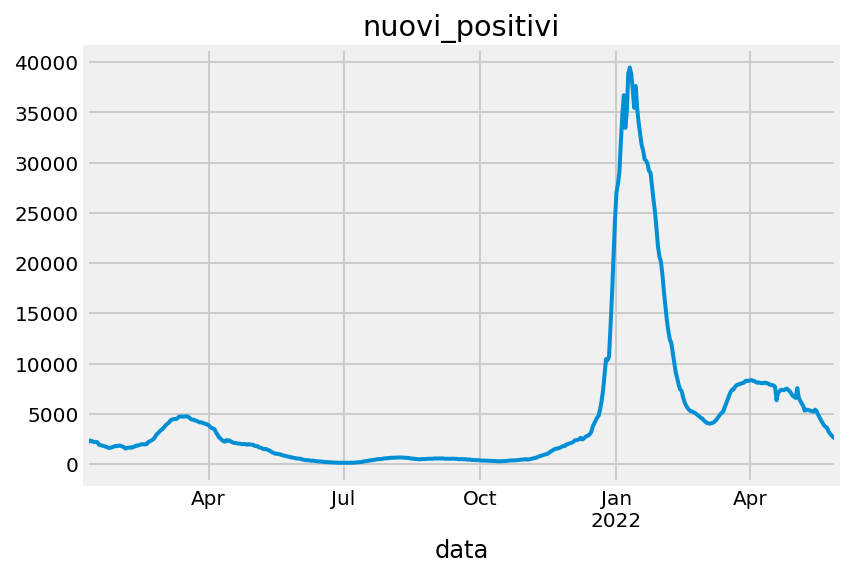

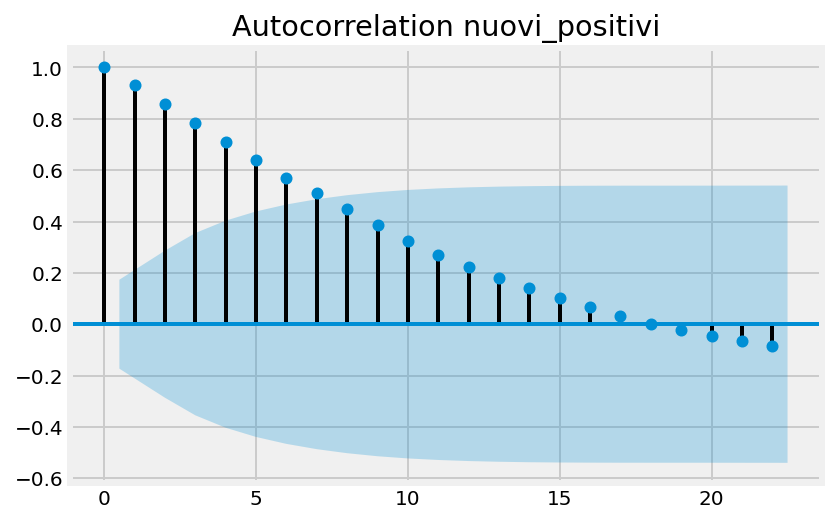

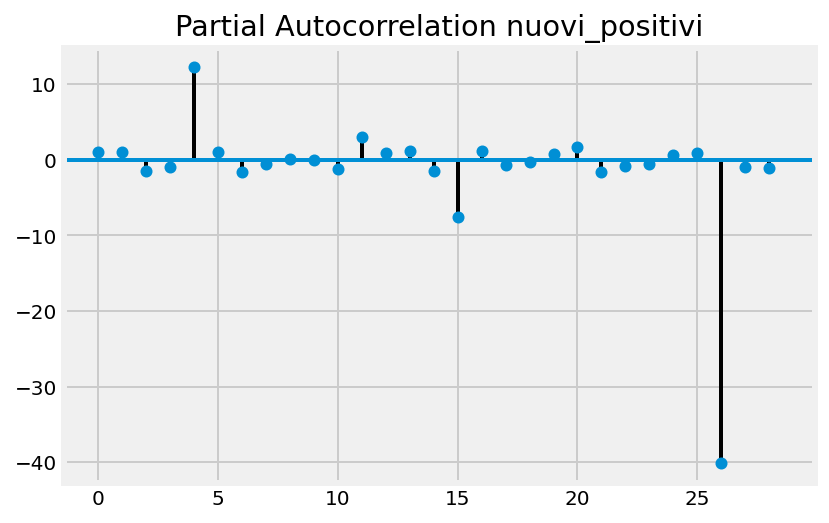

In [5]:
df = preprocessing('Lombardia','2021-01-02','nuovi_positivi', r_window = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
64  7480.455578  6.0  2.0  2.0  10.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:      D2.nuovi_positivi   No. Observations:                  499
Model:                 ARIMA(6, 2, 2)   Log Likelihood               -3709.165
Method:                       css-mle   S.D. of innovations            407.774
Date:                Mon, 06 Jun 2022   AIC                           7438.330
Time:                        18:05:23   BIC                           7480.456
Sample:                    01-10-2021   HQIC                          7454.861
                         - 05-23-2022                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------

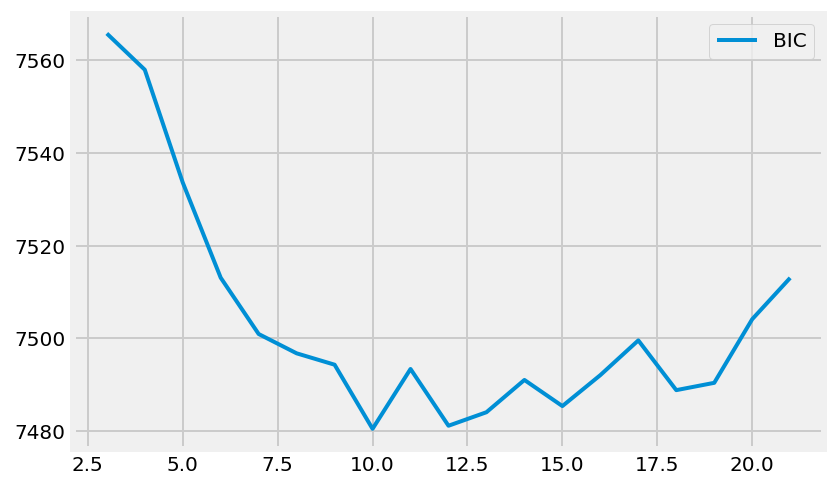

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lombardia', df, 'nuovi_positivi', '2022-05-23', training = False)

130.1333880732944


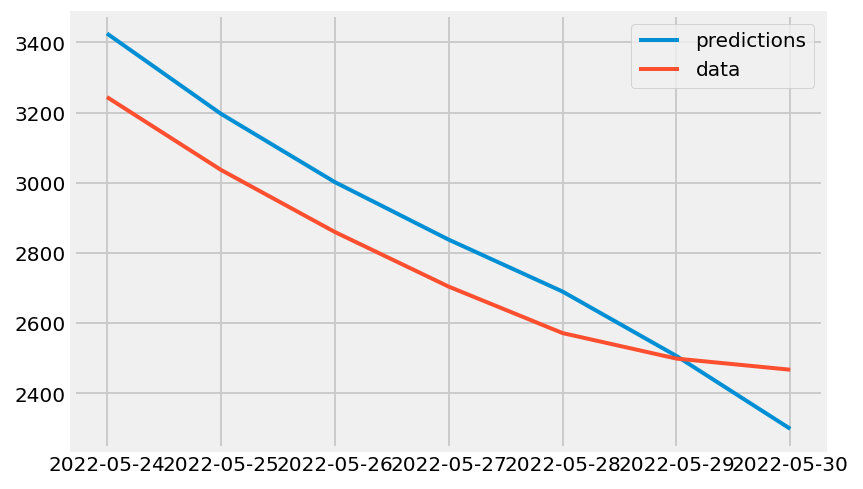

In [ ]:
pred = ARIMA_model.predictions(7,df)

## Nuovi Positivi Lazio


pvalue ADFuller test: 
                 p-value
nuovi_positivi  0.080368


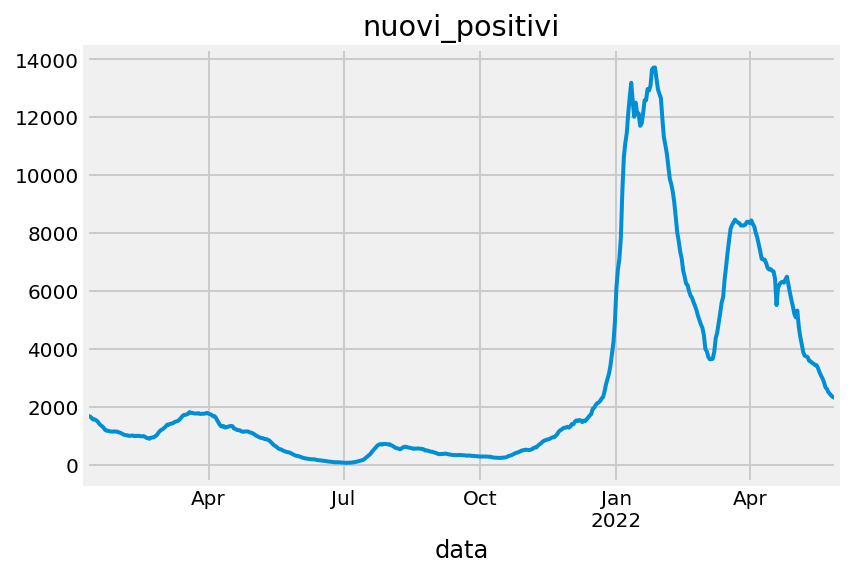

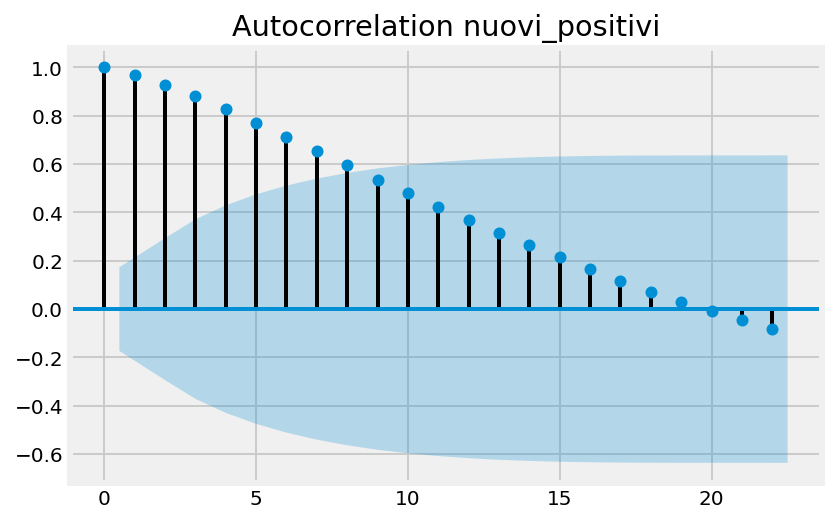

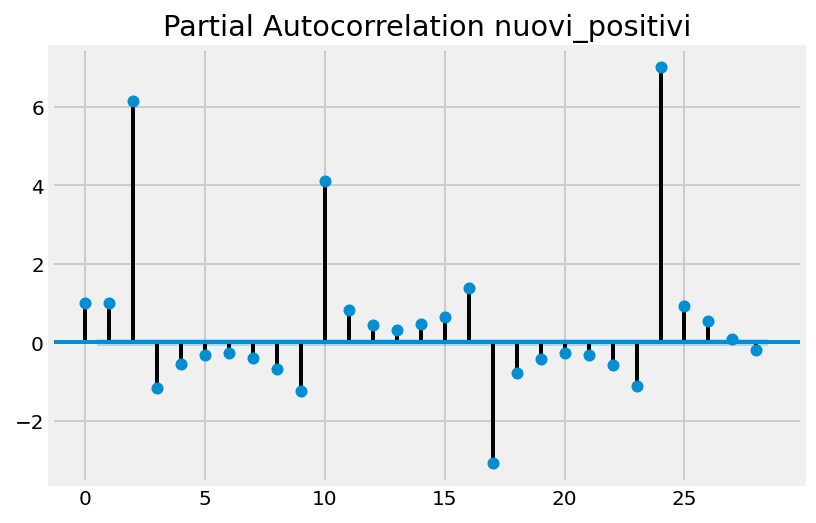

In [ ]:
df = preprocessing('Lazio','2021-01-02','nuovi_positivi', r_window = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
86  6338.868067  7.0  1.0  6.0  14.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:       D.nuovi_positivi   No. Observations:                  500
Model:                 ARIMA(7, 1, 6)   Log Likelihood               -3122.824
Method:                       css-mle   S.D. of innovations            124.160
Date:                Mon, 06 Jun 2022   AIC                           6275.649
Time:                        18:05:42   BIC                           6338.868
Sample:                    01-09-2021   HQIC                          6300.456
                         - 05-23-2022                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------

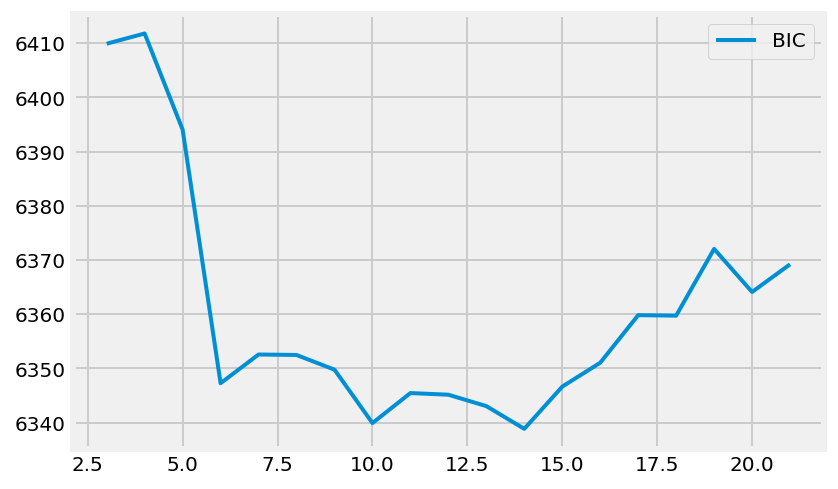

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lazio', df, 'nuovi_positivi', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
64.05993872293955


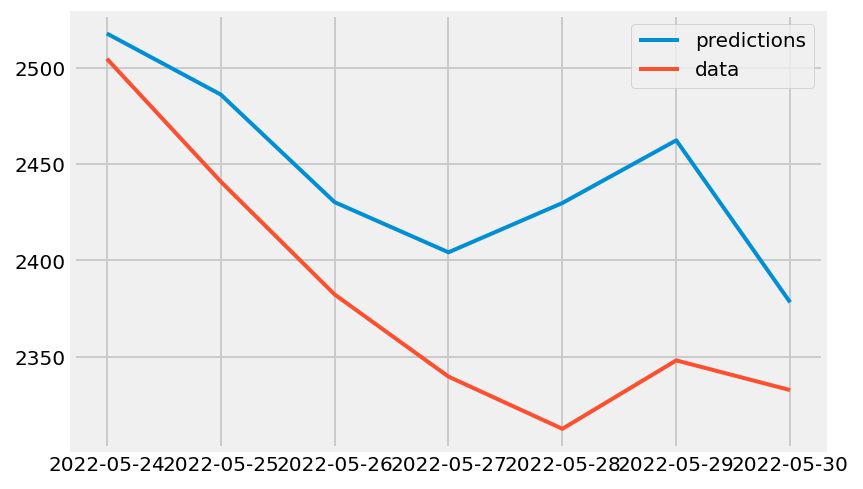

In [ ]:
pred = ARIMA_model.predictions(8,df)

## Nuovi Positivi Sicilia


pvalue ADFuller test: 
                 p-value
nuovi_positivi  0.392279


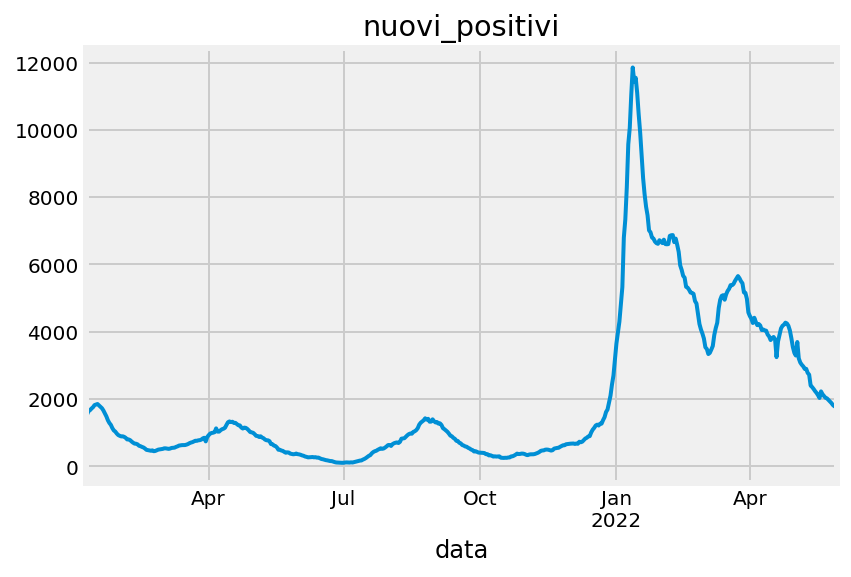

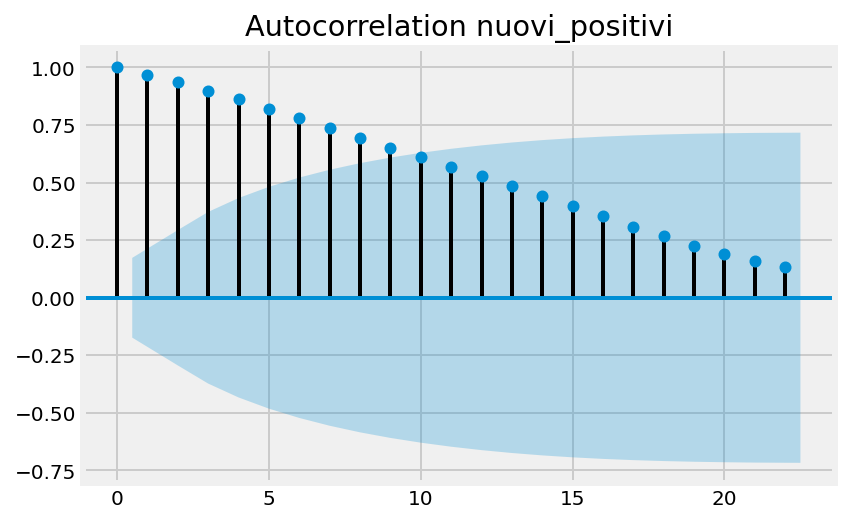

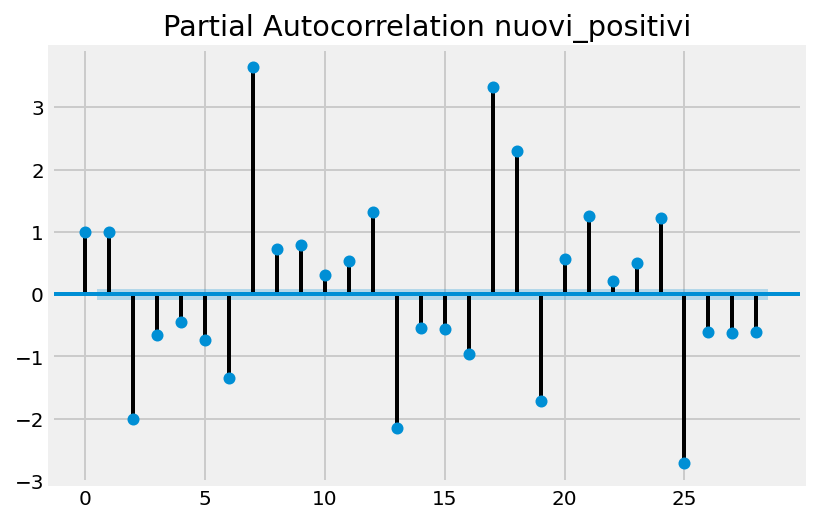

In [ ]:
df = preprocessing('Sicilia','2021-01-02','nuovi_positivi', r_window = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
41  6112.892065  3.0  2.0  7.0  12.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:      D2.nuovi_positivi   No. Observations:                  499
Model:                 ARIMA(3, 2, 7)   Log Likelihood               -3019.170
Method:                       css-mle   S.D. of innovations            101.872
Date:                Mon, 06 Jun 2022   AIC                           6062.341
Time:                        18:05:47   BIC                           6112.892
Sample:                    01-10-2021   HQIC                          6082.179
                         - 05-23-2022                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------

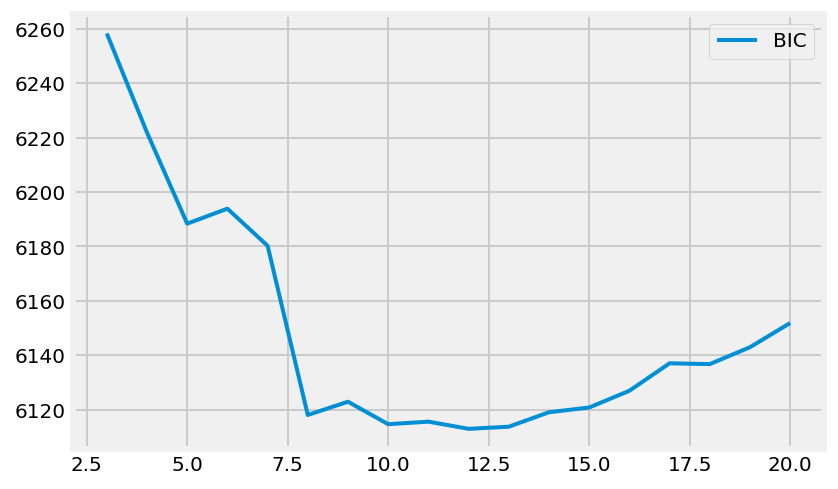

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Sicilia', df, 'nuovi_positivi', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
37.181553815150856


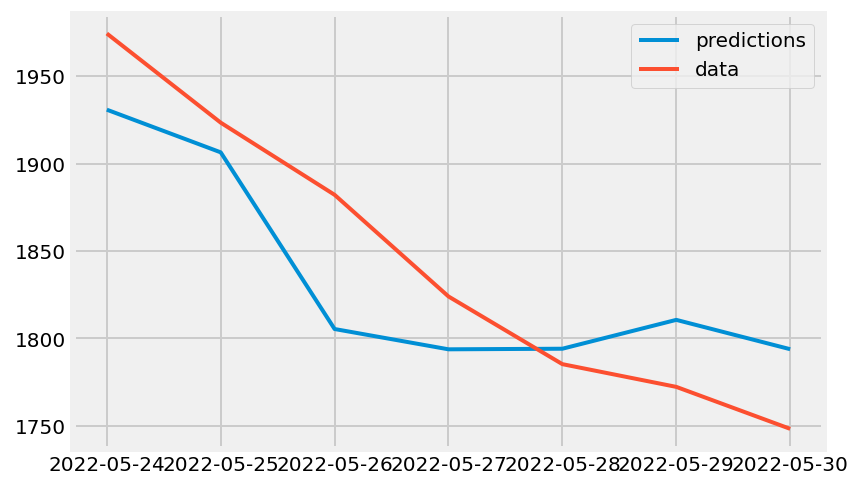

In [ ]:
pred = ARIMA_model.predictions(8,df)

## Dimessi Guariti Lombardia
 

pvalue ADFuller test: 
                        p-value
dimessi_guariti        0.985574
nuovi_dimessi_guariti  0.009615


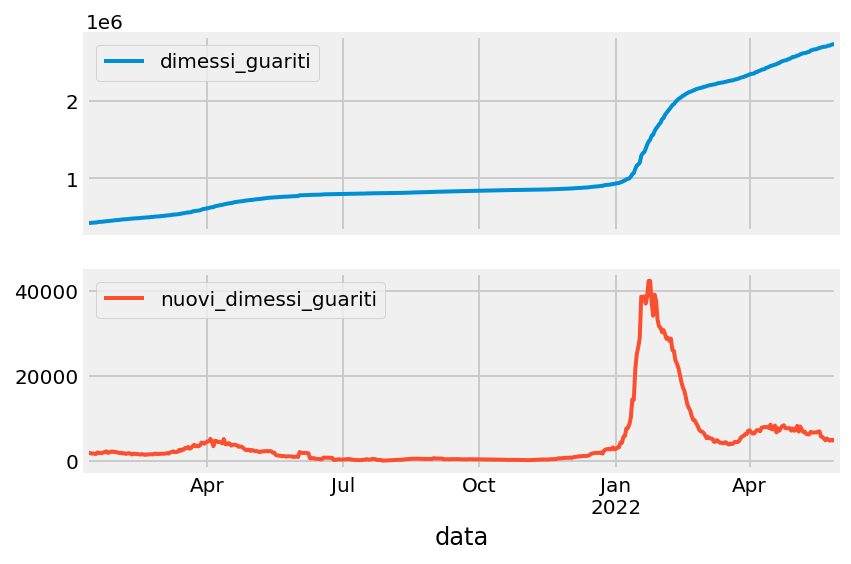

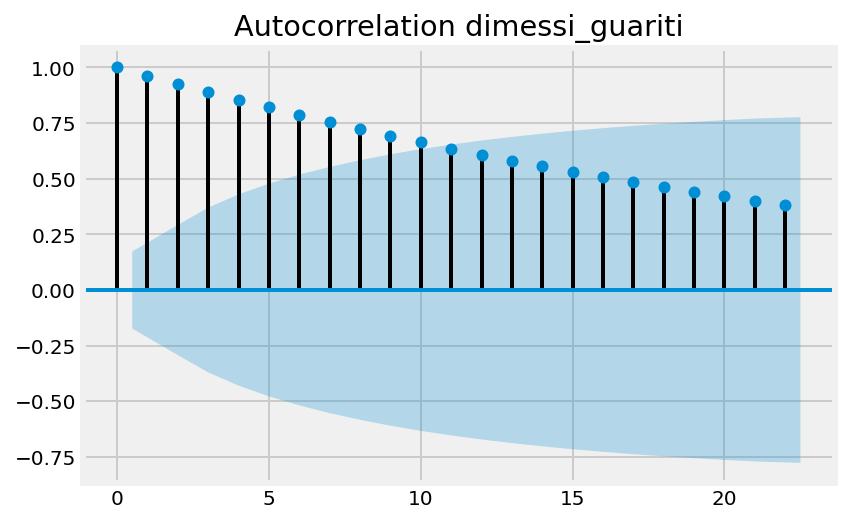

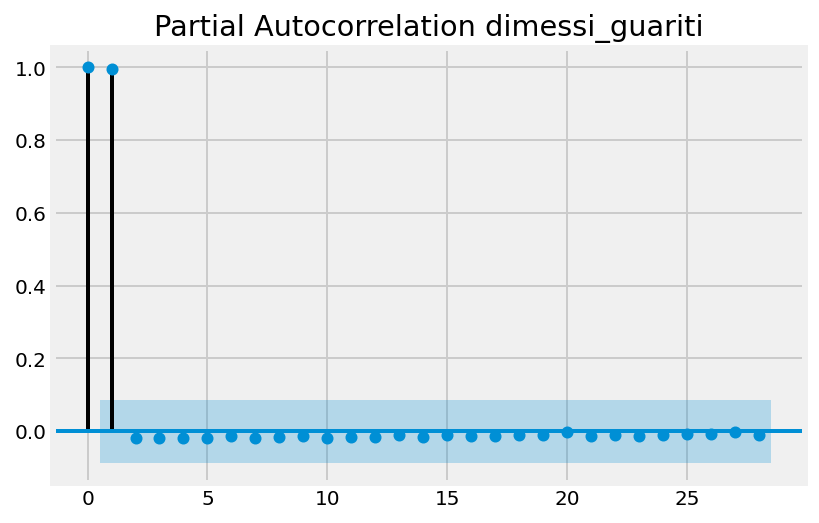

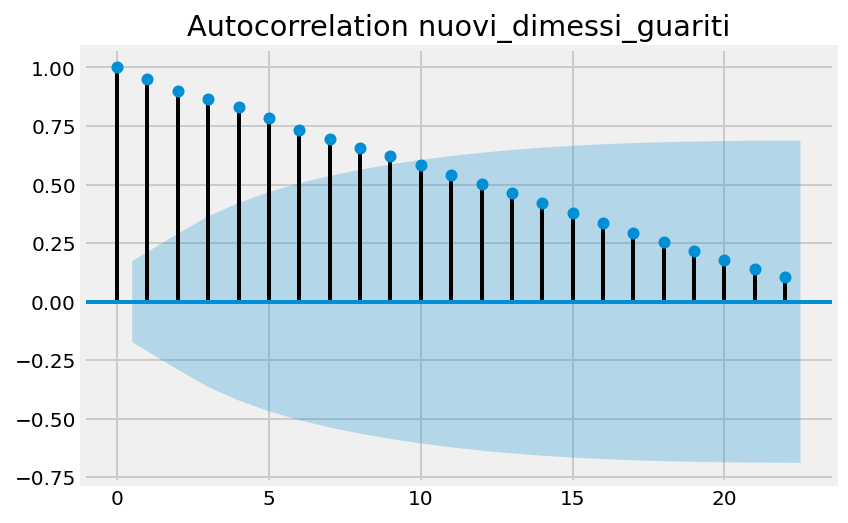

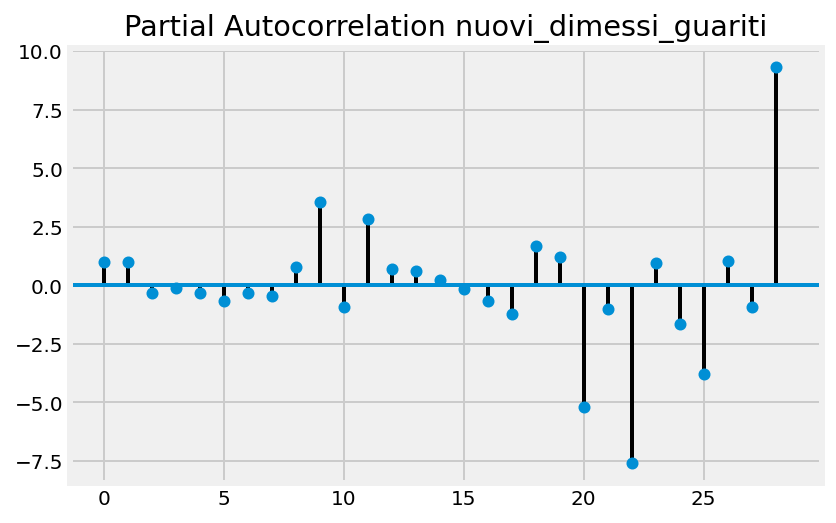

In [ ]:
df = preprocessing('Lombardia','2021-01-02','dimessi_guariti', r_window = 1, diff = True, r_window_diff = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
79  7845.903236  7.0  2.0  7.0  16.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                                ARIMA Model Results                                 
Dep. Variable:     D2.nuovi_dimessi_guariti   No. Observations:                  498
Model:                       ARIMA(7, 2, 7)   Log Likelihood               -3873.267
Method:                             css-mle   S.D. of innovations            565.860
Date:                      Mon, 06 Jun 2022   AIC                           7778.534
Time:                              18:06:03   BIC                           7845.903
Sample:                          01-11-2021   HQIC                          7804.974
                               - 05-23-2022                                         
                                     coef    std err          z

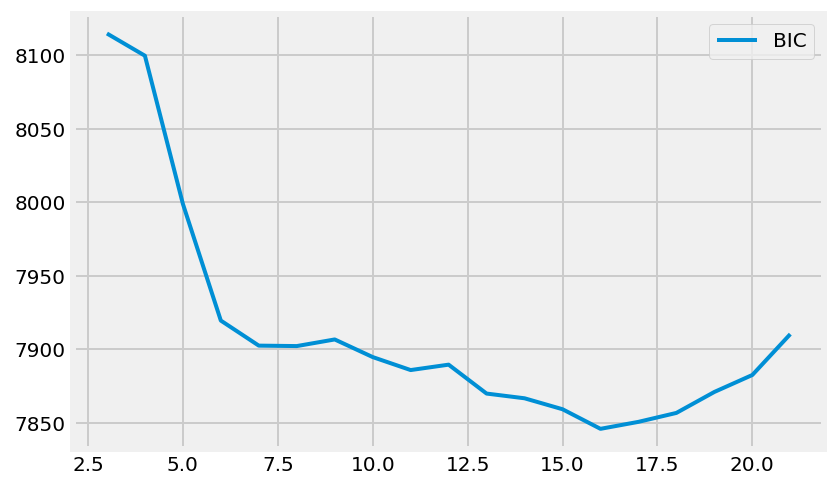

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lombardia', df, 'nuovi_dimessi_guariti', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
4520.179347565664


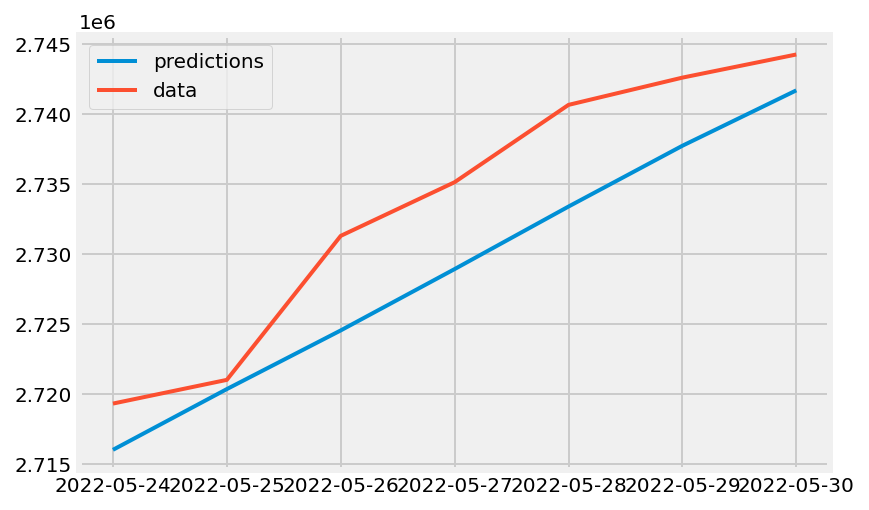

In [ ]:
pred = ARIMA_model.predictions(8,df)

## Dimessi Guariti Lazio

 

pvalue ADFuller test: 
                        p-value
dimessi_guariti        0.992197
nuovi_dimessi_guariti  0.289417


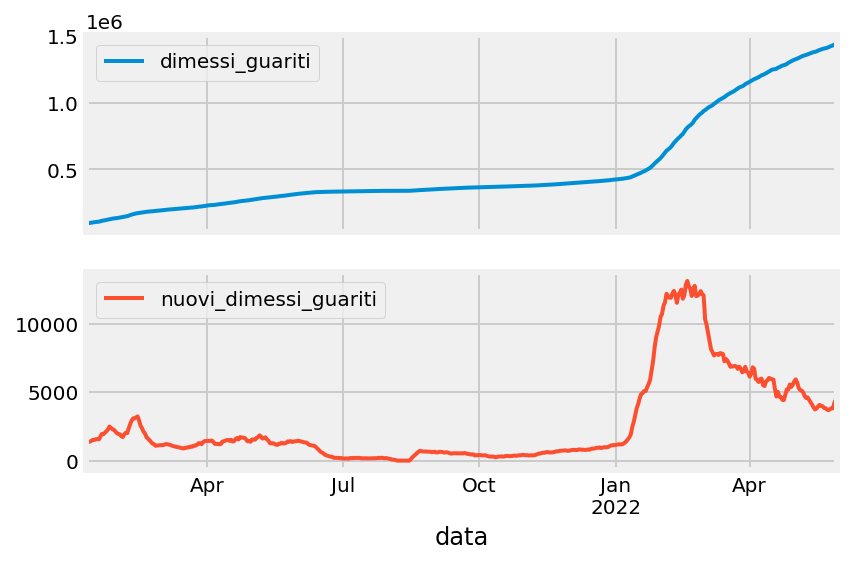

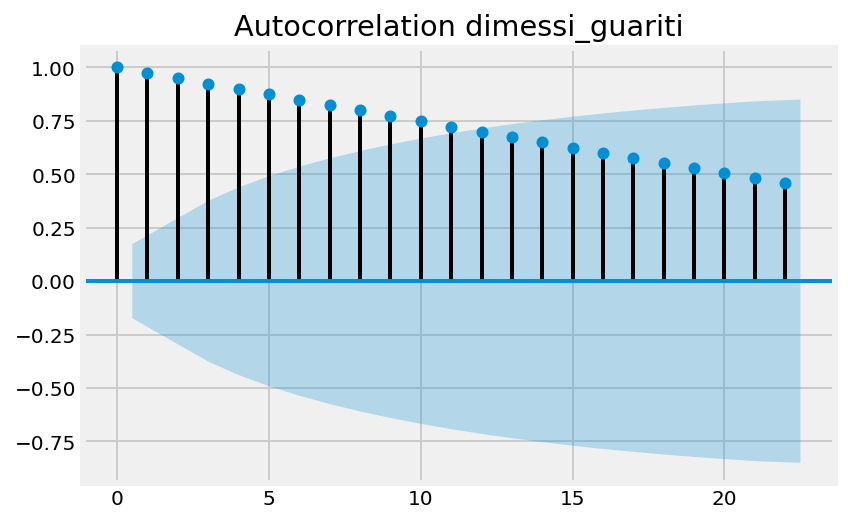

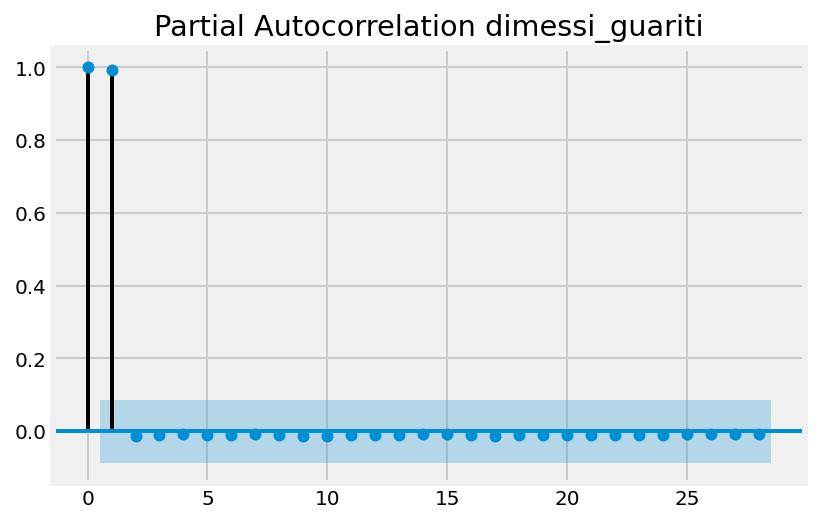

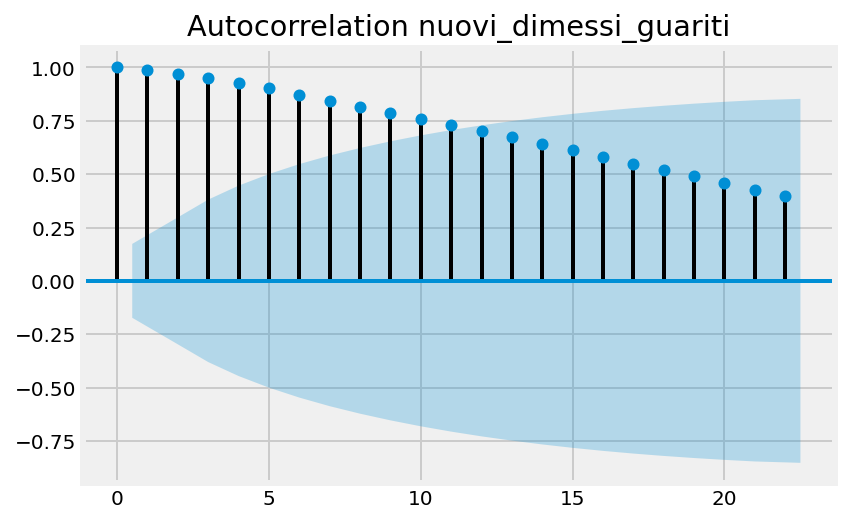

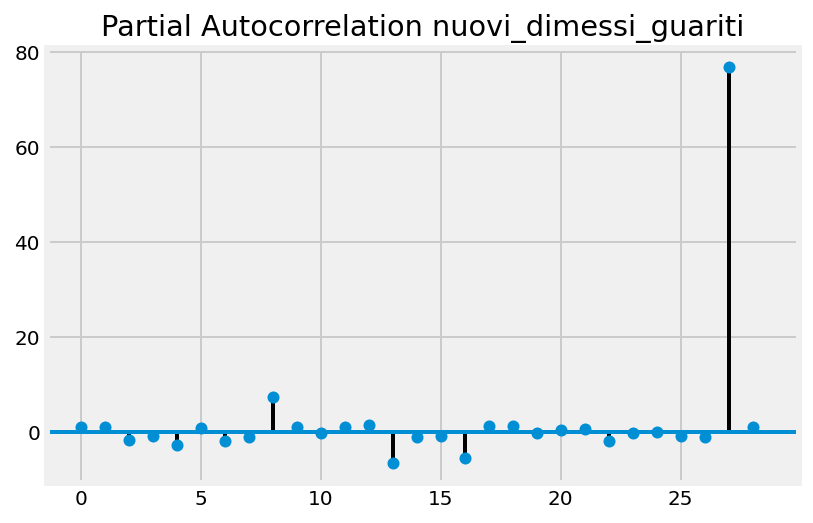

In [ ]:
df = preprocessing('Lazio','2021-01-02','dimessi_guariti', r_window = 1, diff = True, r_window_diff = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
29  6426.273195  3.0  1.0  6.0  10.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                                ARIMA Model Results                                
Dep. Variable:     D.nuovi_dimessi_guariti   No. Observations:                  499
Model:                      ARIMA(3, 1, 6)   Log Likelihood               -3178.967
Method:                            css-mle   S.D. of innovations            139.487
Date:                     Mon, 06 Jun 2022   AIC                           6379.935
Time:                             18:06:22   BIC                           6426.273
Sample:                         01-10-2021   HQIC                          6398.119
                              - 05-23-2022                                         
                                    coef    std err          z      P>|

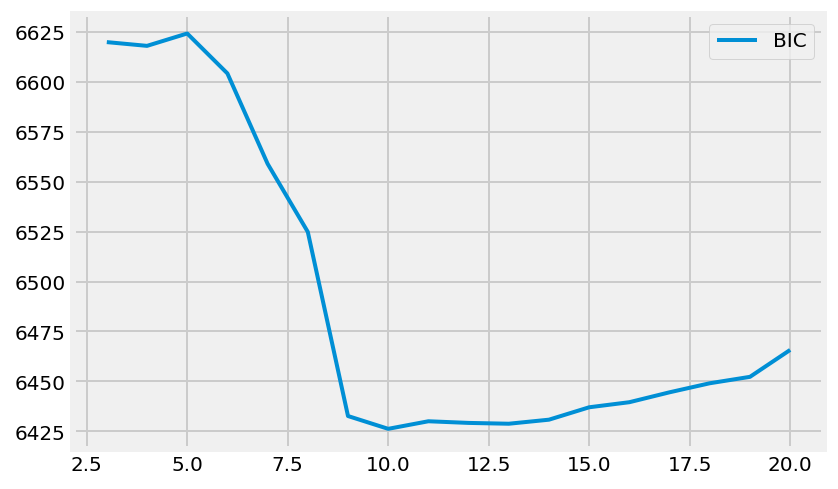

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lazio', df, 'nuovi_dimessi_guariti', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
5172.975440502433


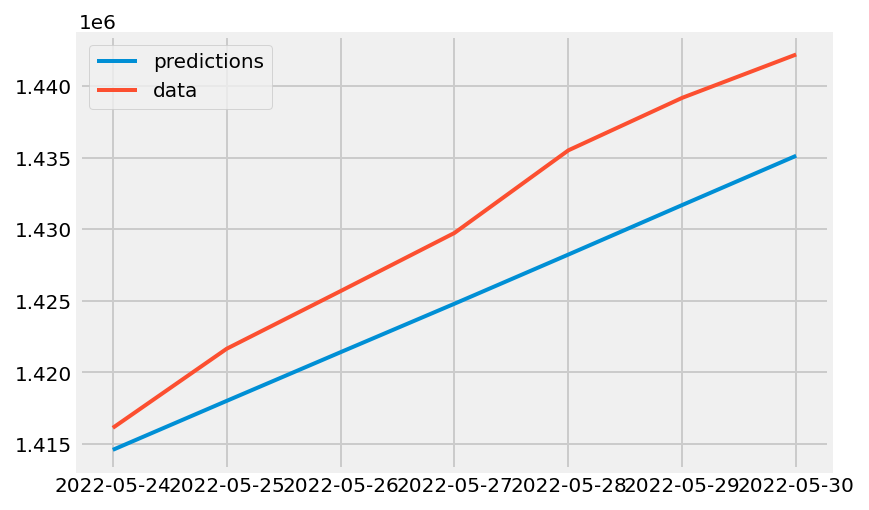

In [ ]:
pred = ARIMA_model.predictions(8,df)

## Dimessi Guariti Sicilia

 

pvalue ADFuller test: 
                        p-value
dimessi_guariti        0.996692
nuovi_dimessi_guariti  0.497809


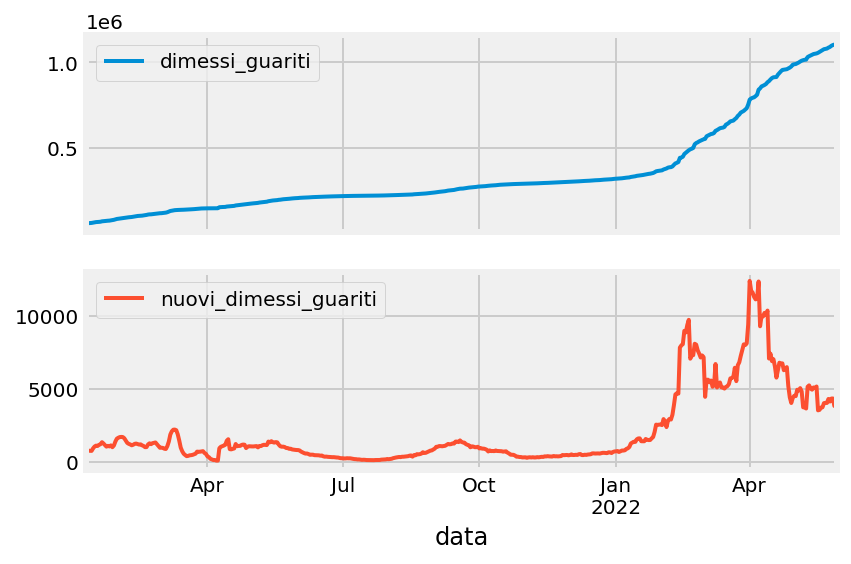

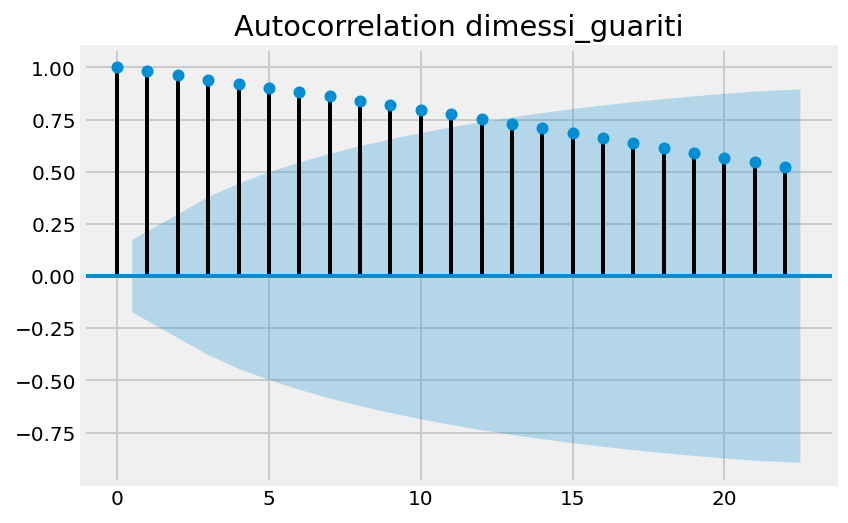

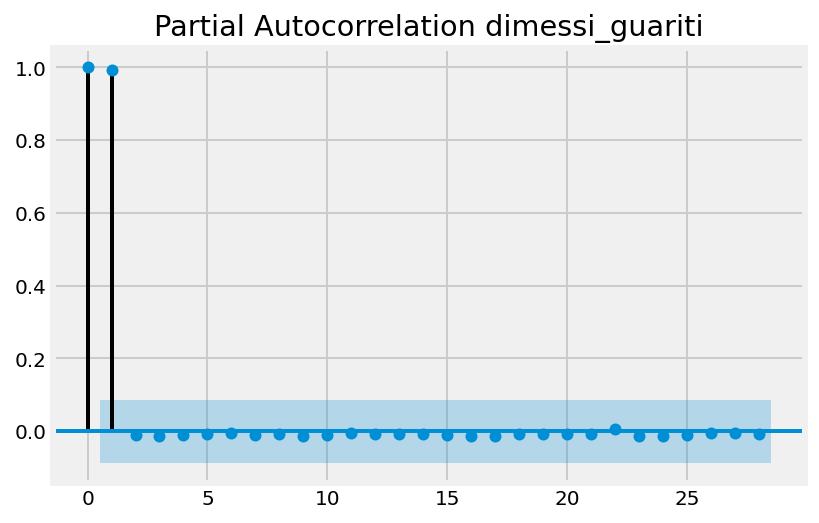

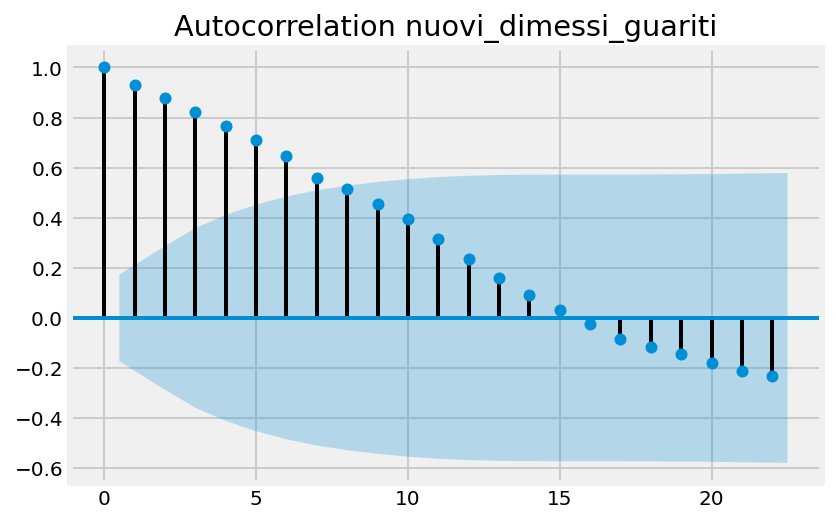

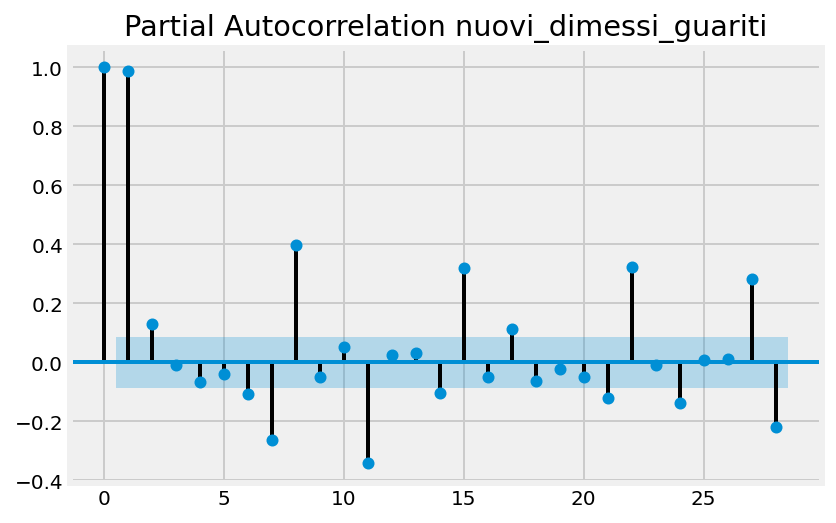

In [ ]:
df = preprocessing('Sicilia','2021-01-02','dimessi_guariti', r_window = 1, diff = True, r_window_diff = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
15  7278.580017  2.0  1.0  7.0  10.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                                ARIMA Model Results                                
Dep. Variable:     D.nuovi_dimessi_guariti   No. Observations:                  499
Model:                      ARIMA(2, 1, 7)   Log Likelihood               -3605.121
Method:                            css-mle   S.D. of innovations            326.268
Date:                     Mon, 06 Jun 2022   AIC                           7232.241
Time:                             18:06:34   BIC                           7278.580
Sample:                         01-10-2021   HQIC                          7250.426
                              - 05-23-2022                                         
                                    coef    std err          z      P>|

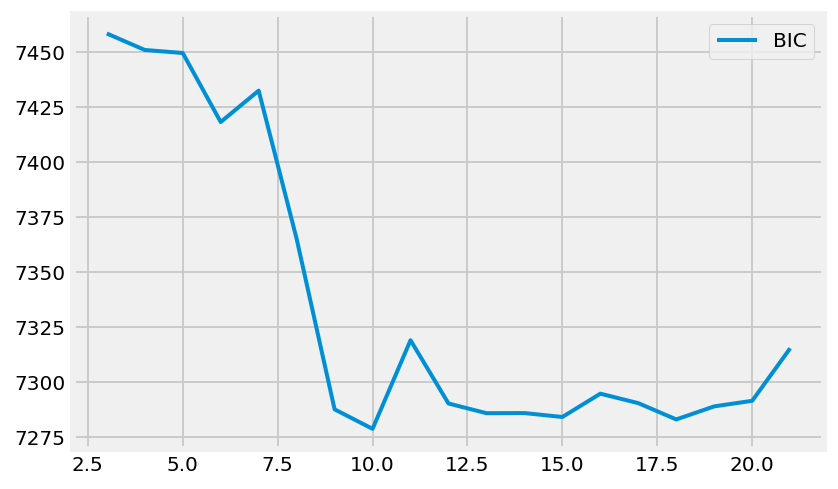

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Sicilia', df, 'nuovi_dimessi_guariti', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
1807.360147637548


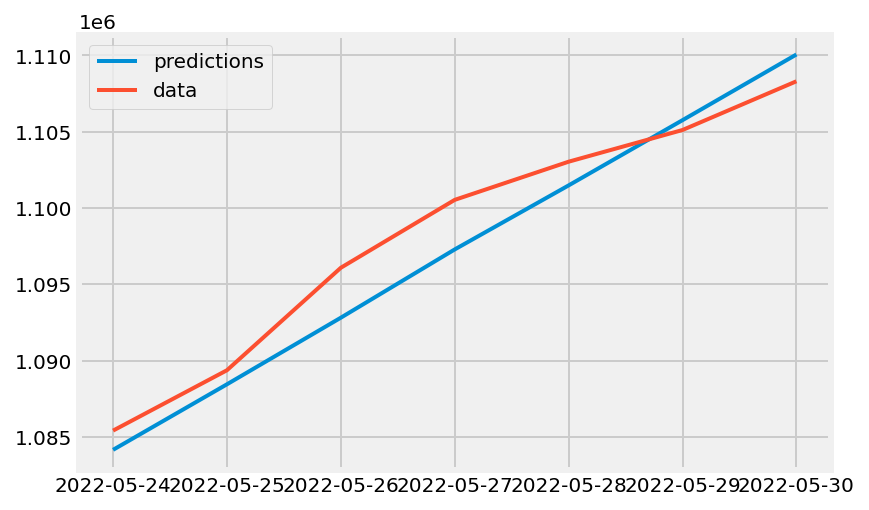

In [ ]:
pred = ARIMA_model.predictions(8,df)

#Deceduti Lombardia 

pvalue ADFuller test: 
                 p-value
deceduti        0.721932
nuovi_deceduti  0.069827


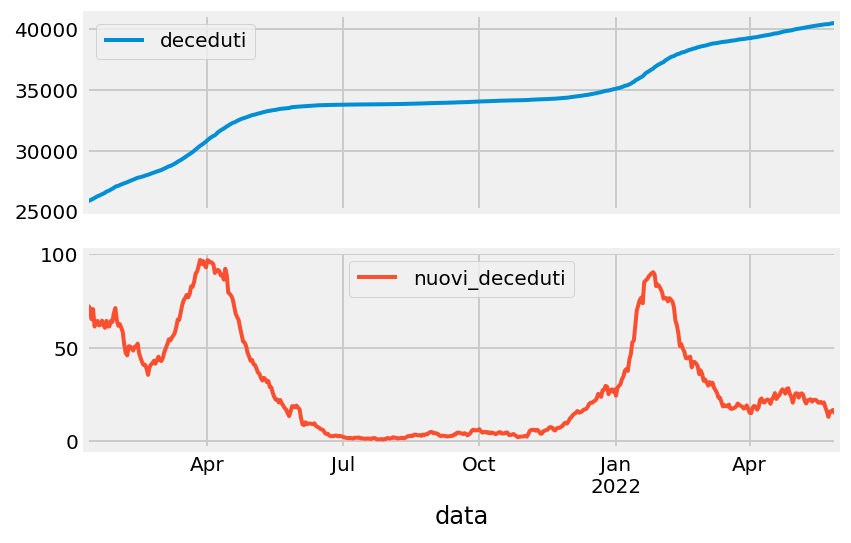

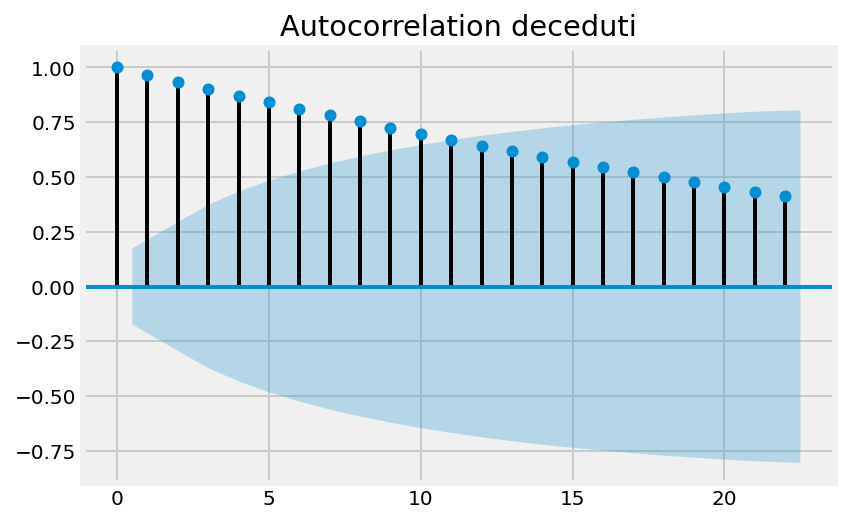

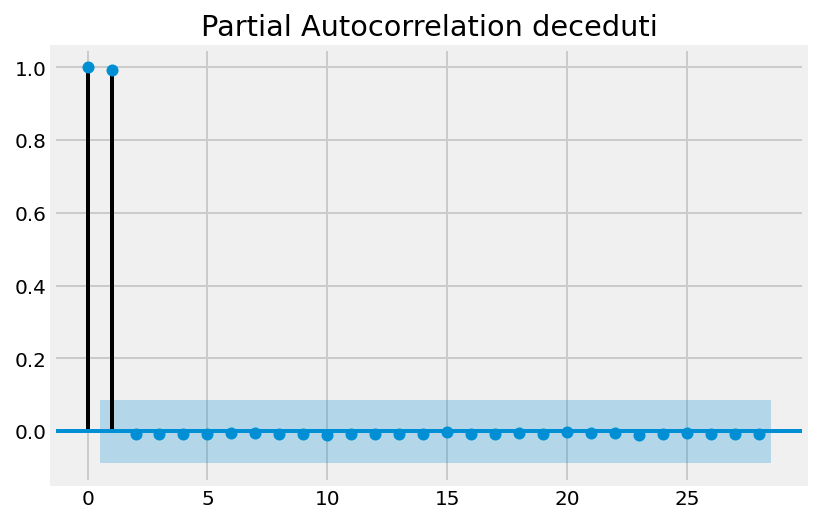

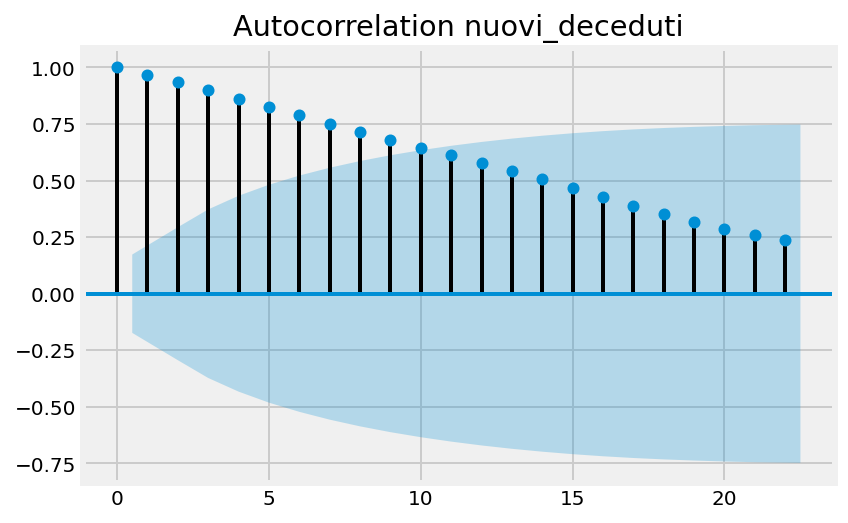

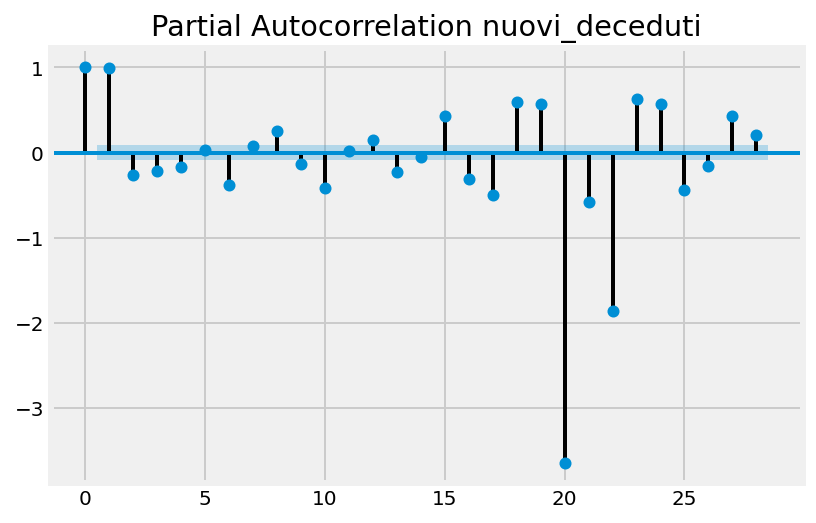

In [ ]:
df = preprocessing('Lombardia','2021-01-02','deceduti', r_window = 1, diff = True, r_window_diff = 7)

the model with the minimum BIC is the following: 
           BIC   ar  dif   ma  dof
6  2008.261578  1.0  1.0  7.0  9.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:       D.nuovi_deceduti   No. Observations:                  499
Model:                 ARIMA(1, 1, 7)   Log Likelihood                -973.068
Method:                       css-mle   S.D. of innovations              1.680
Date:                Mon, 06 Jun 2022   AIC                           1966.136
Time:                        18:06:51   BIC                           2008.262
Sample:                    01-10-2021   HQIC                          1982.667
                         - 05-23-2022                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------

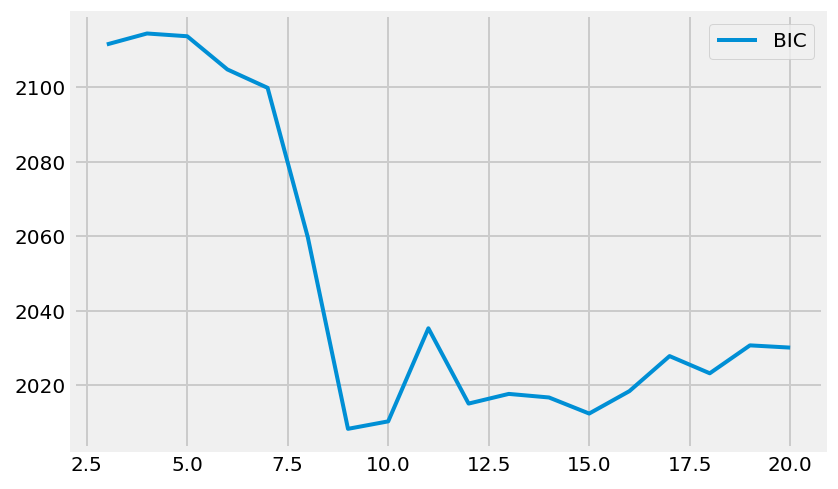

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lombardia', df, 'nuovi_deceduti', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
28.91306822227281


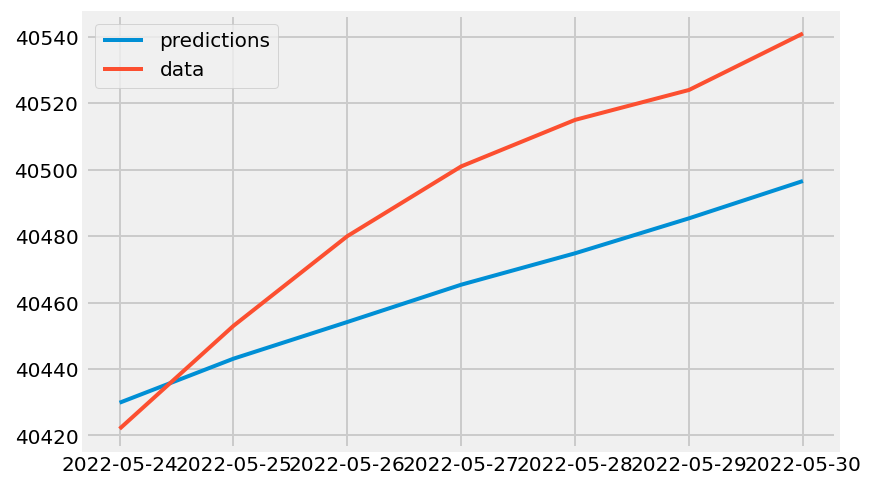

In [ ]:
pred = ARIMA_model.predictions(8,df)

#Deceduti Lazio

pvalue ADFuller test: 
                 p-value
deceduti        0.728285
nuovi_deceduti  0.042287


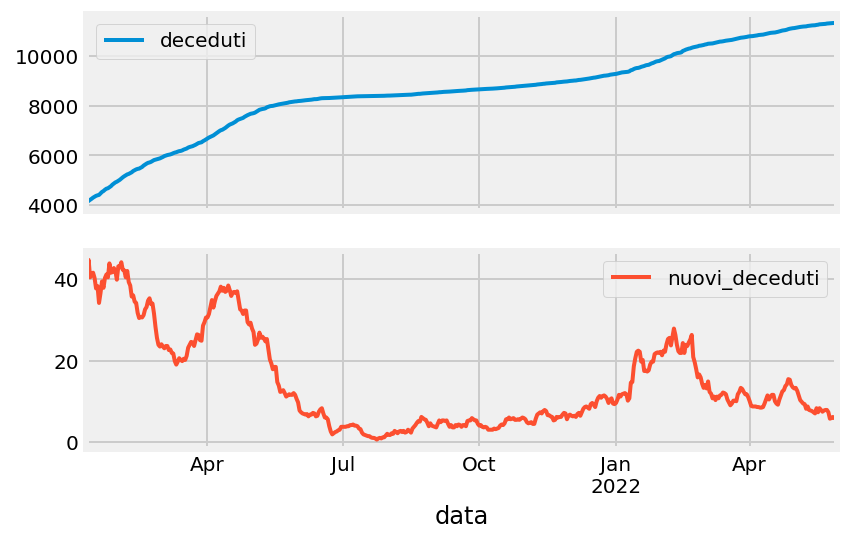

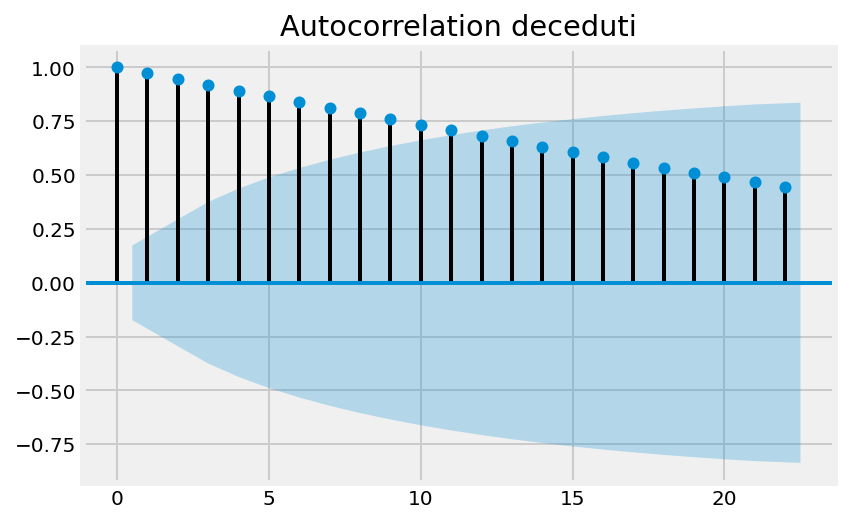

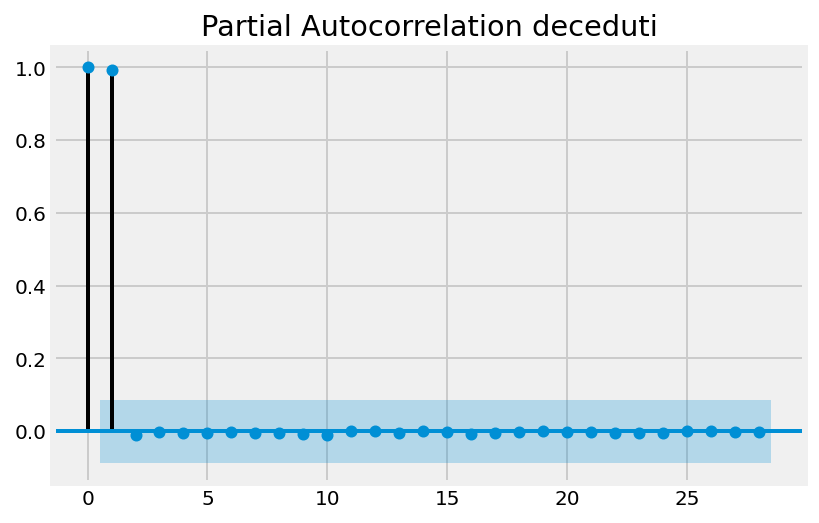

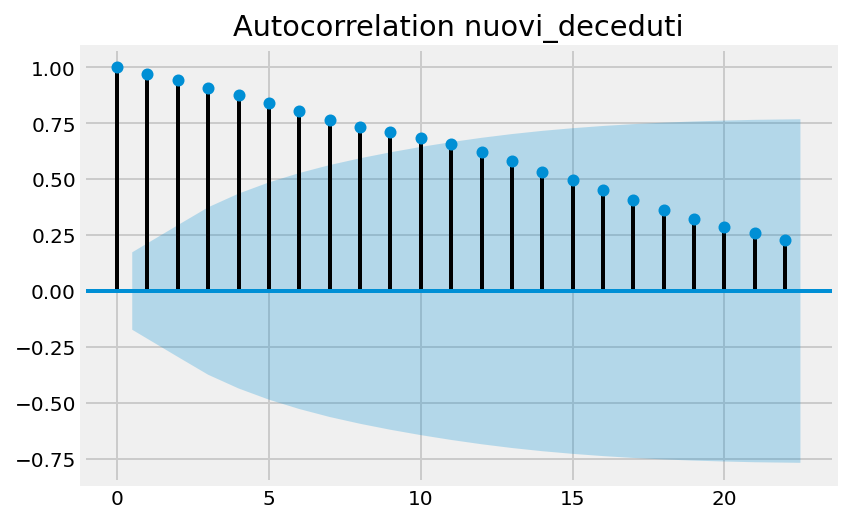

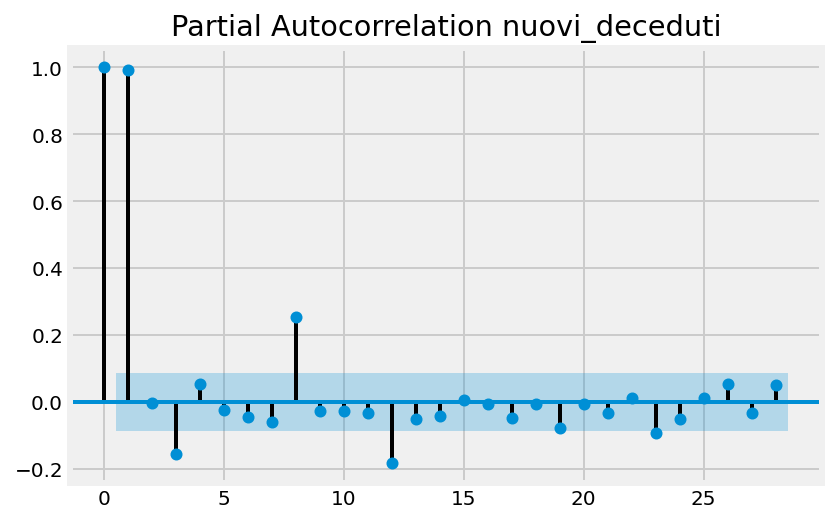

In [ ]:
df = preprocessing('Lazio','2021-01-02','deceduti', r_window = 1, diff = True, r_window_diff = 7)

the model with the minimum BIC is the following: 
           BIC   ar  dif   ma  dof
6  1347.082528  1.0  1.0  7.0  9.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:       D.nuovi_deceduti   No. Observations:                  499
Model:                 ARIMA(1, 1, 7)   Log Likelihood                -642.478
Method:                       css-mle   S.D. of innovations              0.870
Date:                Mon, 06 Jun 2022   AIC                           1304.956
Time:                        18:07:00   BIC                           1347.083
Sample:                    01-10-2021   HQIC                          1321.488
                         - 05-23-2022                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------

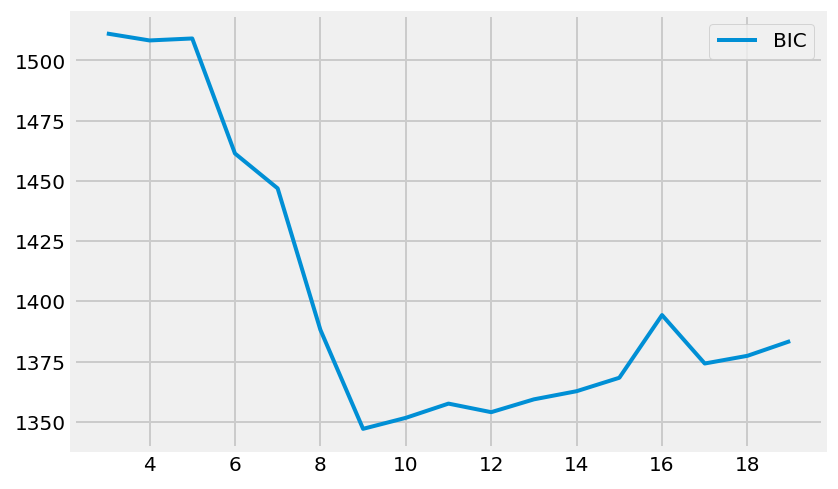

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lazio', df, 'nuovi_deceduti', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
13.834853592555321


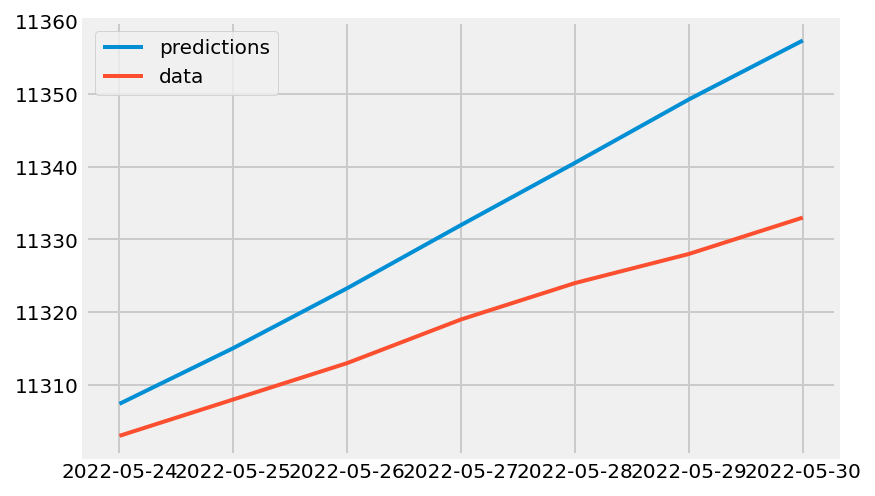

In [ ]:
pred = ARIMA_model.predictions(8,df)

#Deceduti Sicilia

pvalue ADFuller test: 
                 p-value
deceduti        0.959891
nuovi_deceduti  0.033213


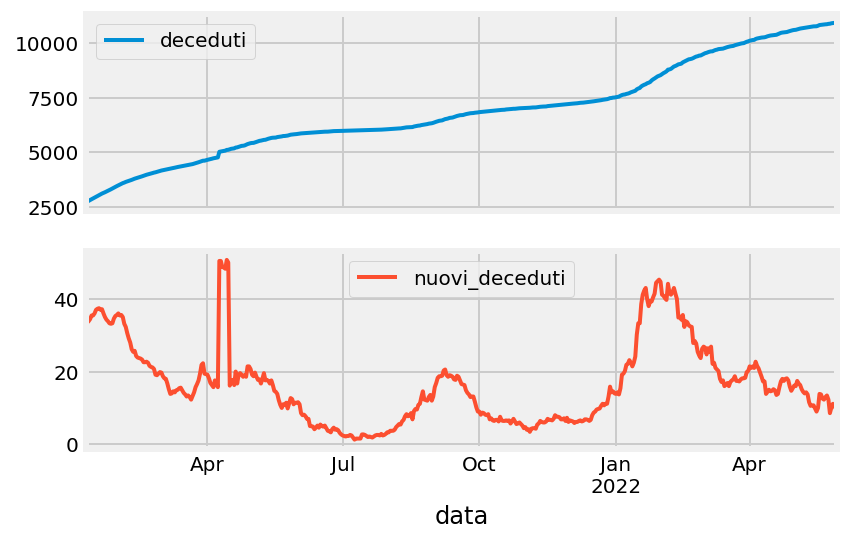

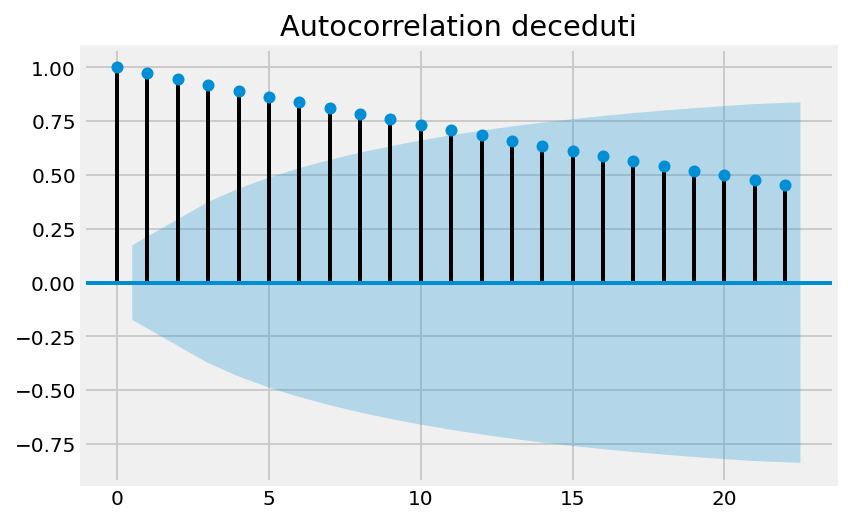

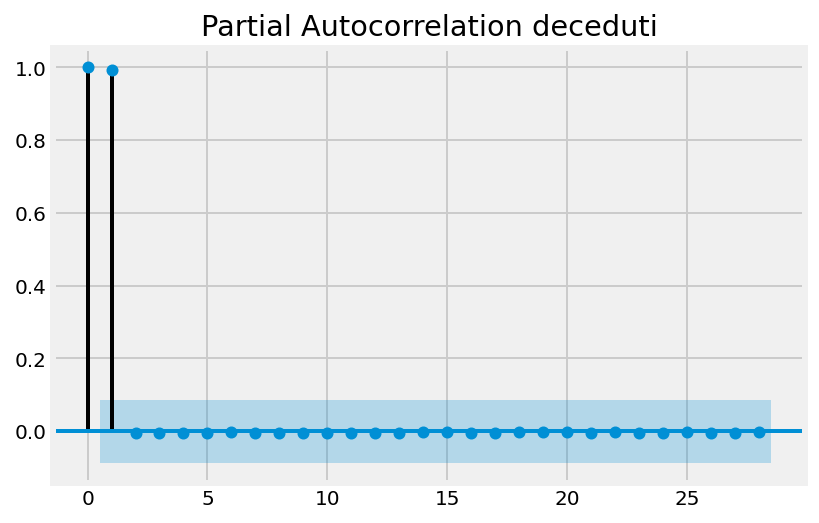

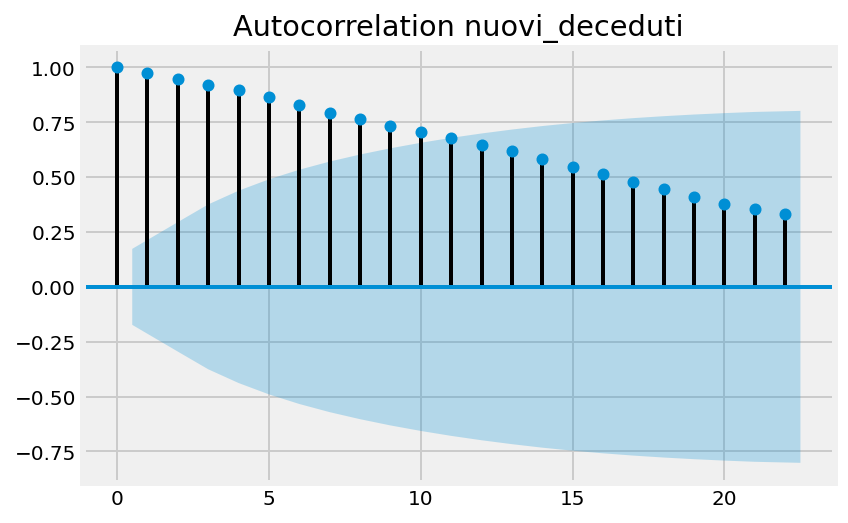

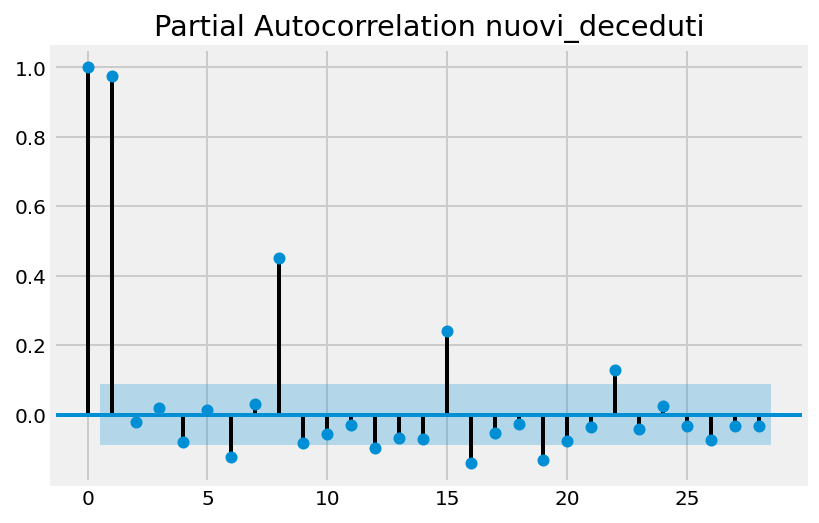

In [ ]:
df = preprocessing('Sicilia','2021-01-02','deceduti', r_window = 1, diff = True, r_window_diff = 7)

the model with the minimum BIC is the following: 
           BIC   ar  dif   ma  dof
6  2131.542899  1.0  1.0  7.0  9.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                             ARIMA Model Results                              
Dep. Variable:       D.nuovi_deceduti   No. Observations:                  499
Model:                 ARIMA(1, 1, 7)   Log Likelihood               -1034.708
Method:                       css-mle   S.D. of innovations              1.900
Date:                Mon, 06 Jun 2022   AIC                           2089.417
Time:                        18:07:08   BIC                           2131.543
Sample:                    01-10-2021   HQIC                          2105.948
                         - 05-23-2022                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------

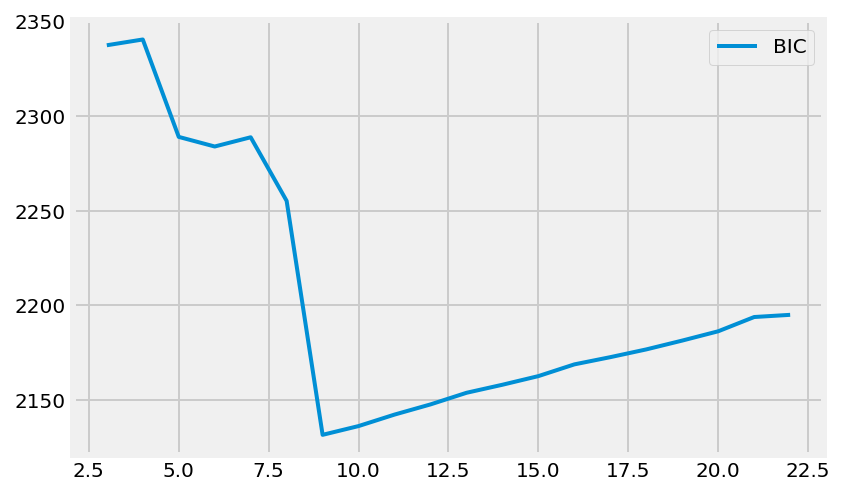

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Sicilia', df, 'nuovi_deceduti', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
6.221863503531755


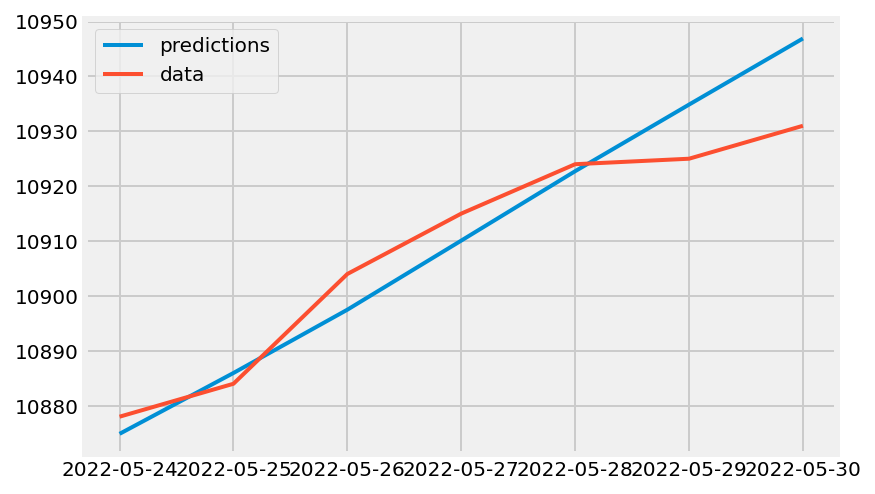

In [ ]:
pred = ARIMA_model.predictions(8,df)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error([1083 ,  40219  ,4294  ,   2671707 , 942 ,11222 , 4095 , 1395747 , 714 , 10742 , 2567 , 1077160], [949 ,  40342  ,  4325   , 2687117 ,
     823 , 11268 , 2883 , 1395410, 662 , 10824 , 2204 , 1060462])


2883.9166666666665

# Ospedalizzati Lombardia 

pvalue ADFuller test: 
                       p-value
totale_ospedalizzati  0.422999


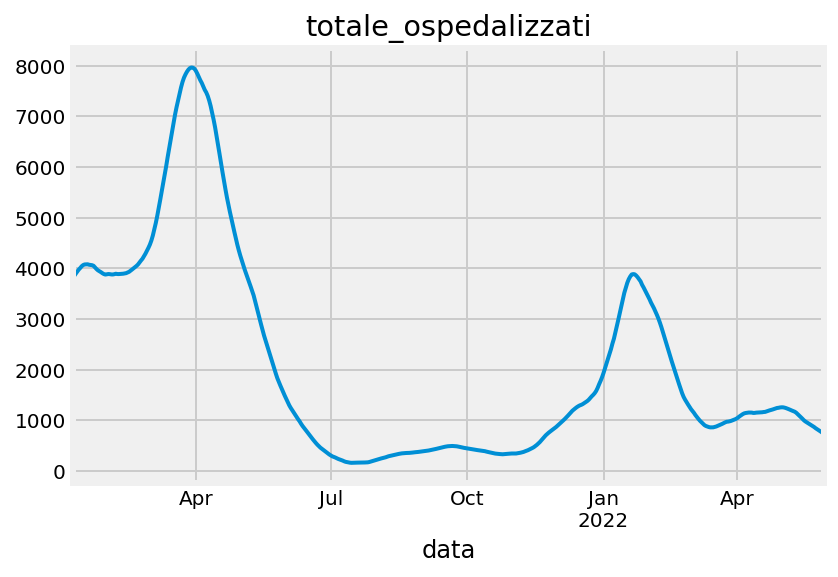

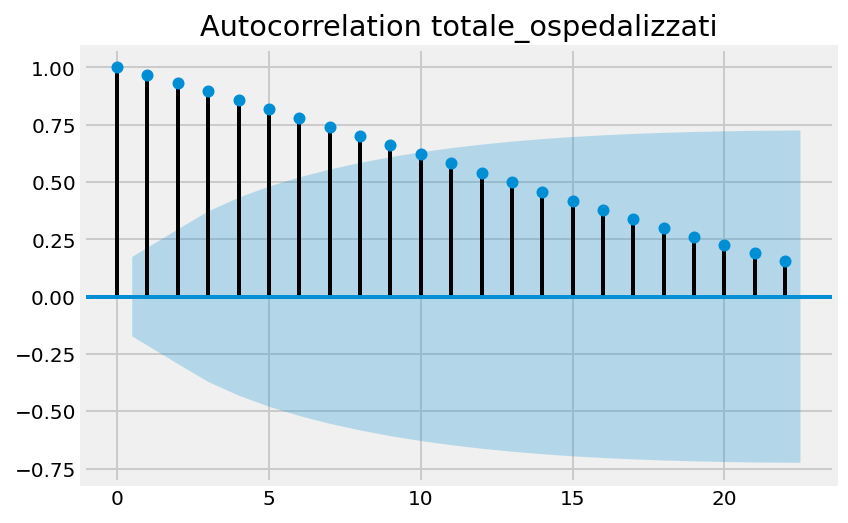

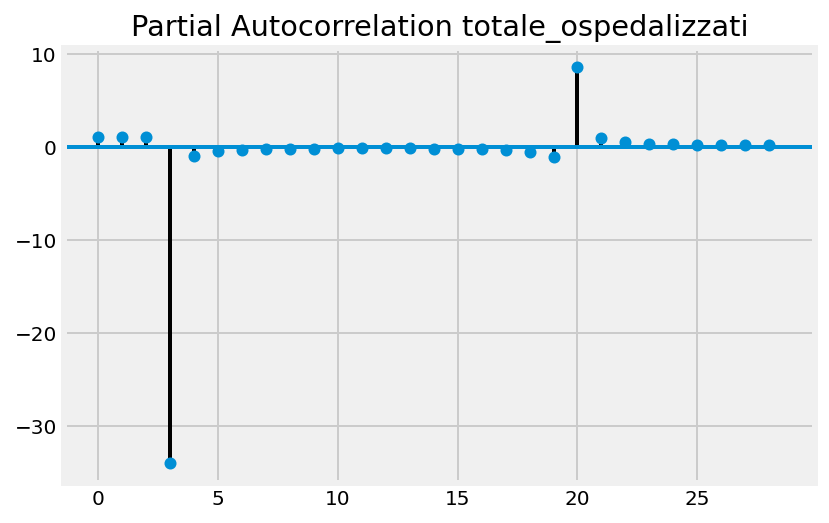

In [ ]:
df = preprocessing('Lombardia','2021-01-02','totale_ospedalizzati', r_window = 7)

the model with the minimum BIC is the following: 
           BIC   ar  dif   ma   dof
40  3154.32655  3.0  2.0  6.0  11.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                                ARIMA Model Results                                
Dep. Variable:     D2.totale_ospedalizzati   No. Observations:                  499
Model:                      ARIMA(3, 2, 6)   Log Likelihood               -1542.994
Method:                            css-mle   S.D. of innovations              5.287
Date:                     Mon, 06 Jun 2022   AIC                           3107.988
Time:                             18:07:15   BIC                           3154.327
Sample:                         01-10-2021   HQIC                          3126.173
                              - 05-23-2022                                         
                                    coef    std err          z      P>|z|

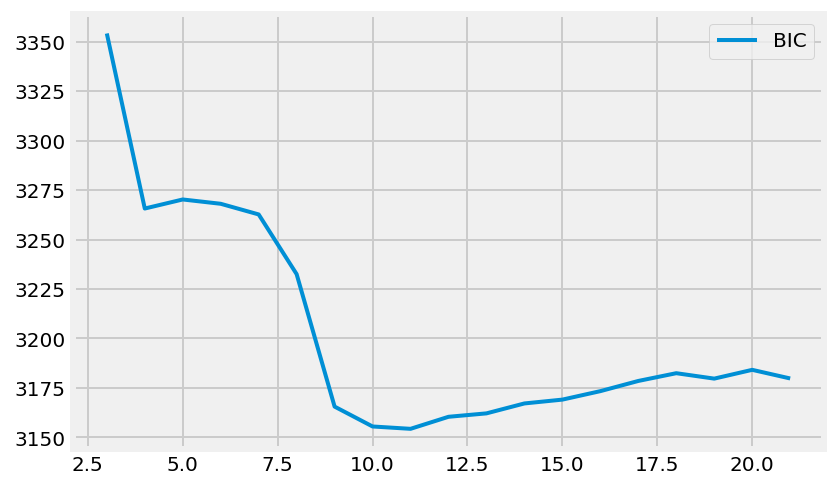

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lombardia', df, 'totale_ospedalizzati', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
18.22217974374564


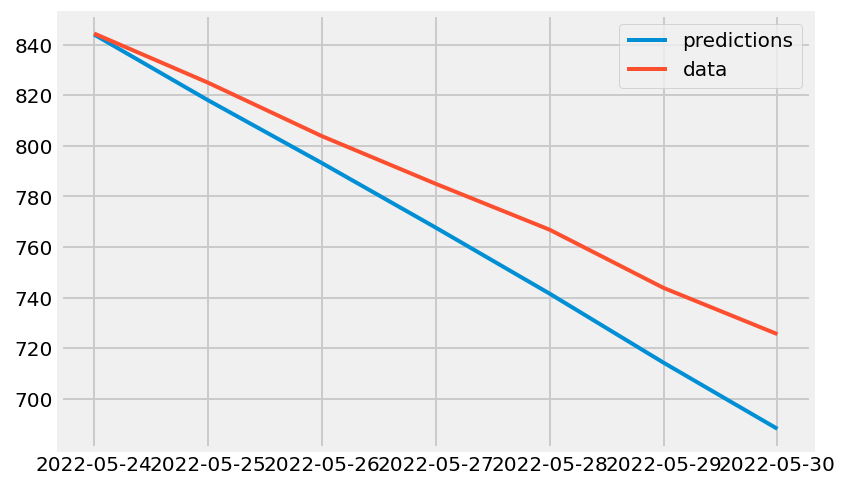

In [ ]:
pred = ARIMA_model.predictions(8,df)

# Ospedalizzati Lazio 

pvalue ADFuller test: 
                       p-value
totale_ospedalizzati  0.461581


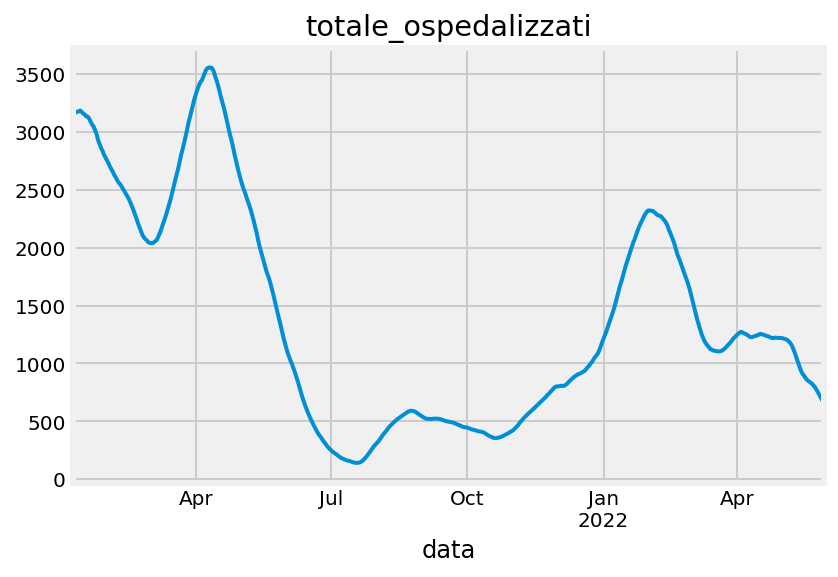

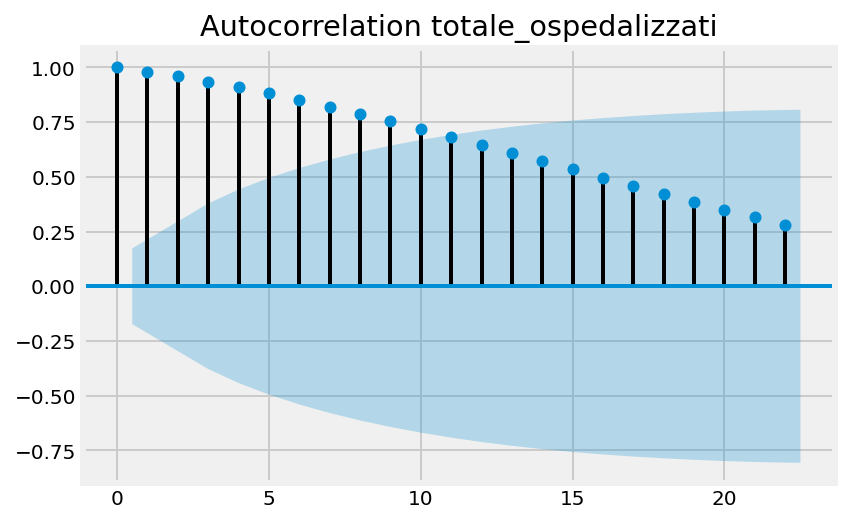

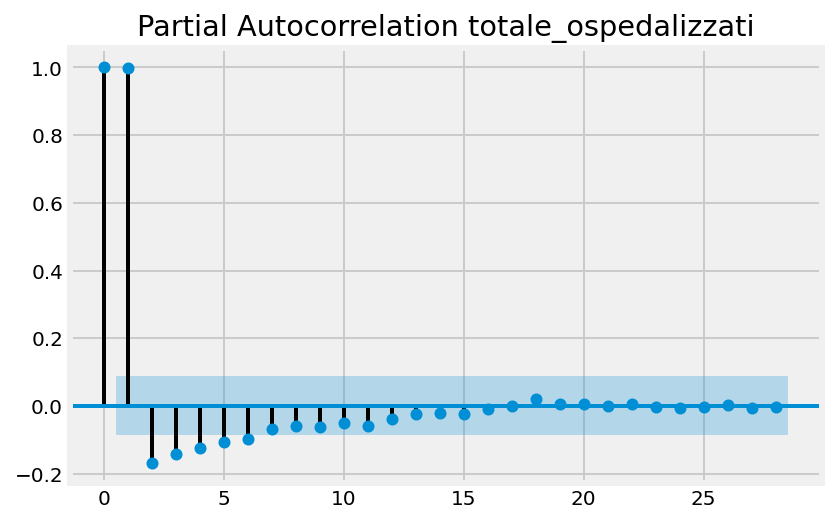

In [ ]:
df = preprocessing('Lazio','2021-01-02','totale_ospedalizzati', r_window = 7)

the model with the minimum BIC is the following: 
            BIC   ar  dif   ma   dof
13  2857.208641  1.0  2.0  7.0  10.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                                ARIMA Model Results                                
Dep. Variable:     D2.totale_ospedalizzati   No. Observations:                  499
Model:                      ARIMA(1, 2, 7)   Log Likelihood               -1397.541
Method:                            css-mle   S.D. of innovations              3.923
Date:                     Mon, 06 Jun 2022   AIC                           2815.083
Time:                             18:07:40   BIC                           2857.209
Sample:                         01-10-2021   HQIC                          2831.614
                              - 05-23-2022                                         
                                    coef    std err          z      P>|

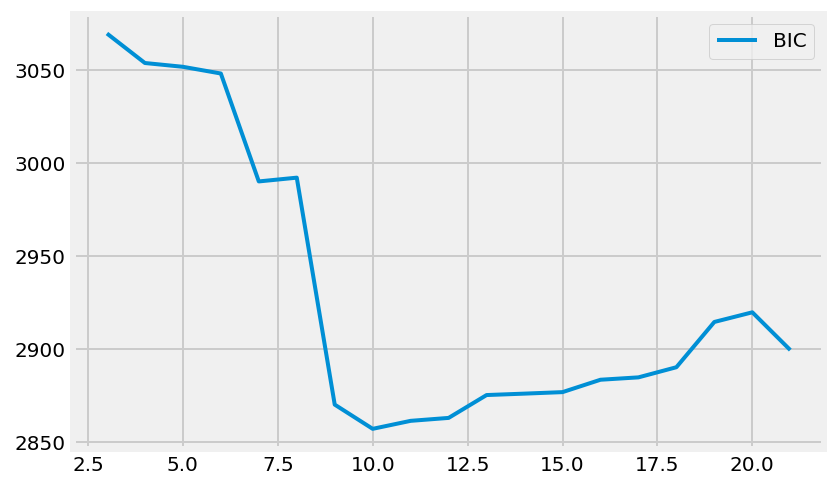

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Lazio', df, 'totale_ospedalizzati', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
28.70668103901557


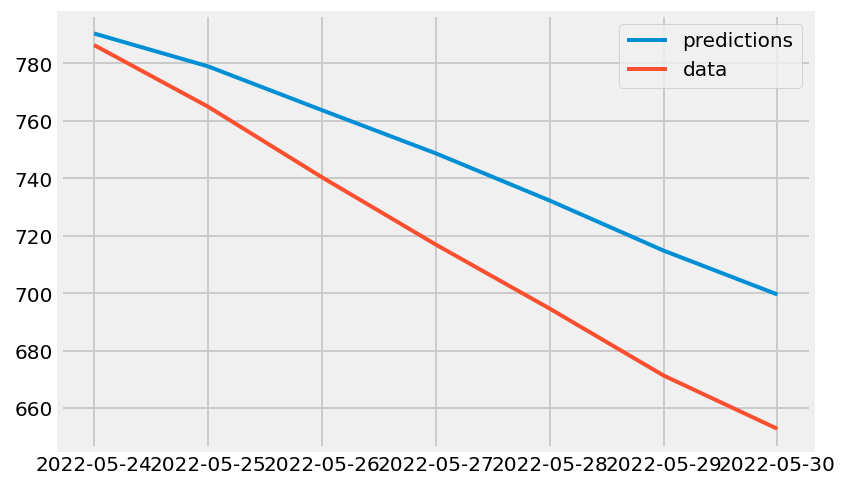

In [ ]:
pred = ARIMA_model.predictions(8,df)

# Ospedalizzati Sicilia 

pvalue ADFuller test: 
                       p-value
totale_ospedalizzati  0.035262


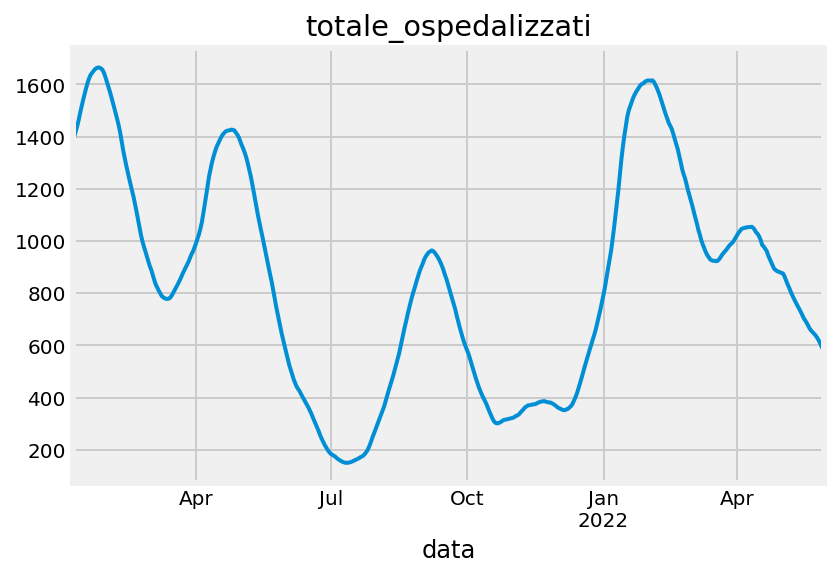

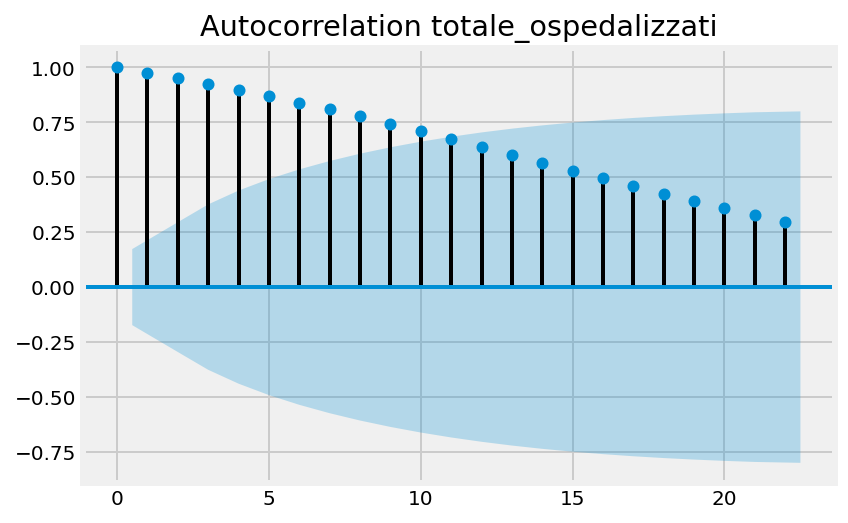

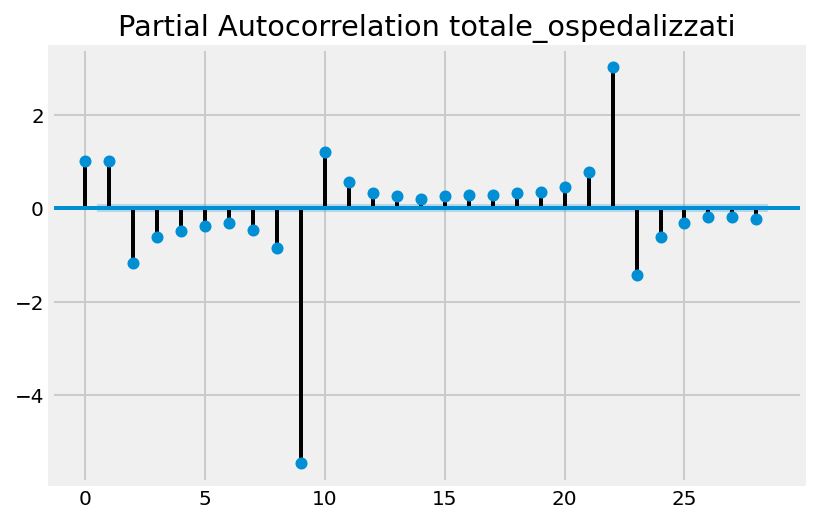

In [ ]:
df = preprocessing('Sicilia','2021-01-02','totale_ospedalizzati', r_window = 7)

the model with the minimum BIC is the following: 
           BIC   ar  dif   ma   dof
13  2252.14657  1.0  2.0  7.0  10.0
this model has been trained using data up to 2022-05-23
----------------------------------------------------------------------------
                                ARIMA Model Results                                
Dep. Variable:     D2.totale_ospedalizzati   No. Observations:                  499
Model:                      ARIMA(1, 2, 7)   Log Likelihood               -1095.010
Method:                            css-mle   S.D. of innovations              2.131
Date:                     Mon, 06 Jun 2022   AIC                           2210.021
Time:                             18:08:06   BIC                           2252.147
Sample:                         01-10-2021   HQIC                          2226.552
                              - 05-23-2022                                         
                                    coef    std err          z      P>|z|

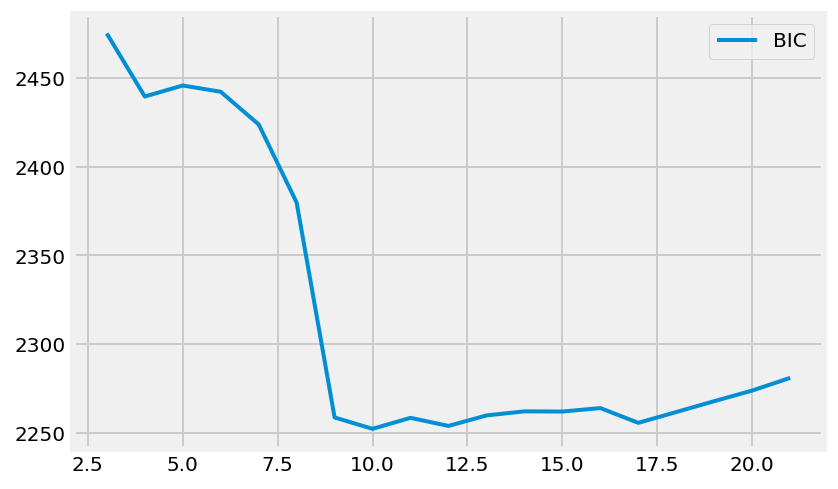

In [ ]:
ARIMA_model = fit_ARIMA()
result = ARIMA_model.fit('Sicilia', df, 'totale_ospedalizzati', '2022-05-23', training = False)

prediction interval larger than test set, thus the prediction steps are reduced
15.21542186054741


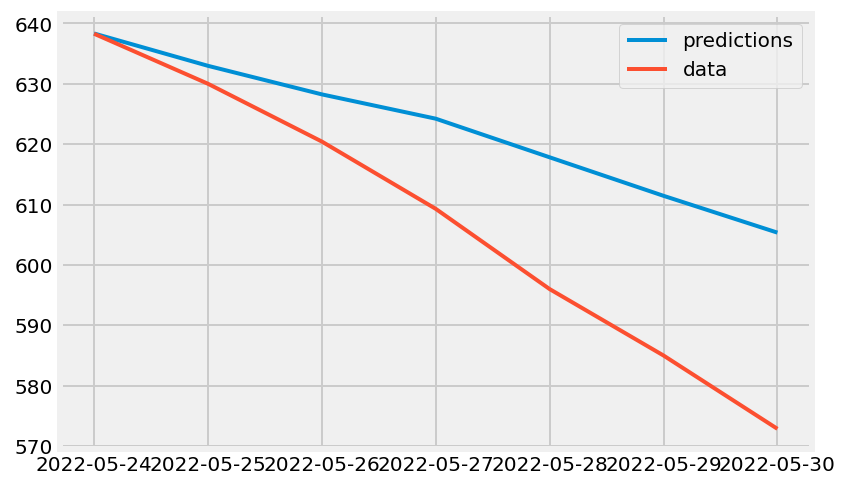

In [ ]:
pred = ARIMA_model.predictions(8,df)